In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import datetime
import calendar
from datetime import date       

In [28]:
df = pd.read_csv(r"dataset/rideshare_kaggle_cleaned.csv")

In [29]:
df.head(15)
print(df[df['price'].isnull()])
print(df[(df['name'] == 'Taxi') & (df['price'].notnull())])
print(f"{df['price'].isnull().sum() * 100/df.shape[0]} % of the price values are missing")
df = df[df['price'].notnull()]
print(f"{df['price'].isnull().sum() * 100/df.shape[0]} % of the price values are missing")

        hour  day  month            source       destination cab_type  name  \
18        14    1     12         North End          West End     Uber  Taxi   
31        23    2     12       Beacon Hill     South Station     Uber  Taxi   
40        20   29     11     North Station            Fenway     Uber  Taxi   
60        20   13     12         North End          West End     Uber  Taxi   
69        13   30     11         North End       Beacon Hill     Uber  Taxi   
...      ...  ...    ...               ...               ...      ...   ...   
693025    15   15     12     South Station       Beacon Hill     Uber  Taxi   
693047     1   29     11  Haymarket Square       Beacon Hill     Uber  Taxi   
693049     1   29     11         North End       Beacon Hill     Uber  Taxi   
693060     5    2     12  Theatre District  Haymarket Square     Uber  Taxi   
693068    23    1     12          West End         North End     Uber  Taxi   

        price  distance  surge_multiplier  ...    s

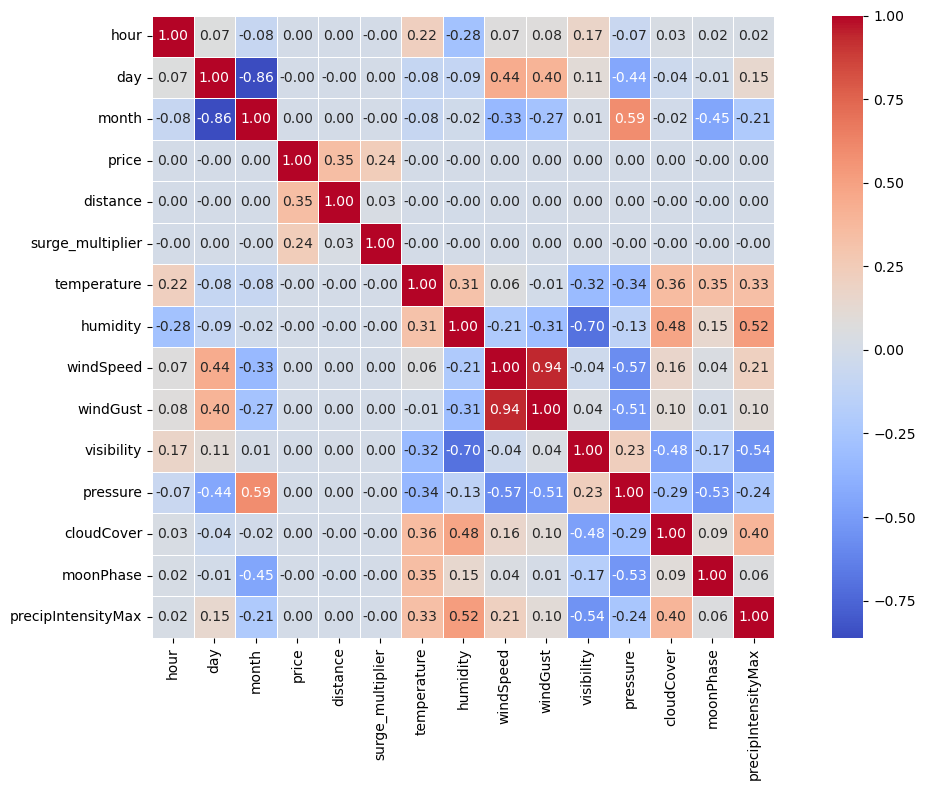

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi'] = 350  

# Calculate the correlation matrix
corr_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

# Optional: Adjust the layout for better appearance if necessary
plt.tight_layout()

# Show the plot
plt.show()


In [30]:
df = df.drop(['windGust','month'], axis=1)

In [31]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 

random_state =42
y = df['price']
X = df.loc[:, df.columns != 'price']

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_ftrs = ['hour','day','day_of_week','cab_type','destination','source','short_summary','name']
num_ftrs = ['surge_multiplier','distance','temperature','humidity','windSpeed','visibility','pressure','cloudCover','moonPhase','precipIntensityMax']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

In [8]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import pandas as pd 


# function for the ML pipeline as outlined above 
def MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    
    Parameters:
    X (array-like): Feature matrix.
    y (array-like): Target variable.
    preprocessor (ColumnTransformer): An instance of ColumnTransformer for preprocessing the data.
    ML_algo (estimator): An uninitialized machine learning algorithm.
    param_grid (dict): Parameter grid for the ML algorithm to be optimized in GridSearchCV.

    Returns:
    list: A list of 10 test RMSE scores.
    list: A list of the 10 best models (estimators).
    '''
    
    # lists to be returned 
    test_scores = []
    test_r2_socres = []
    best_models = []
    def set_random_state_if_possible(ML_algo, random_state=42):
        """
        Set the random_state of ML_algo if it supports it.

        Parameters:
        ML_algo: Machine Learning algorithm instance.
        random_state (int): The random state to set.

        Returns:
        ML_algo: Machine Learning algorithm instance with random_state set if applicable.
        """
        try: 
            ML_algo.set_params(**{'random_state': random_state})
        except:
            print(f"ML_algo does not have a random_state attribute. Skipping...")
        return ML_algo
    
    set_random_state_if_possible(ML_algo)
    # your code here...
    for random_state in range(10):
        # Split your data 
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
        
        # KFold with 4 folds
        kf = KFold(n_splits=4, shuffle=True, random_state=random_state)
        
        # Create a pipeline that first preprocesses the data and then fits the ML algorithm
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', ML_algo)])
        
        # GridSearchCV with KFold
        grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error', return_train_score=True)
        grid_search.fit(X_other, y_other)
        
        # Best model
        best_model = grid_search.best_estimator_
        best_models.append(best_model)
        
        # Calculate the model's error on the test set
        y_test_pred = best_model.predict(X_test)
        rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        r2 = best_model.score(X_test, y_test)
        test_scores.append(rmse)
        test_r2_socres.append(r2)
        
        # Print the results
        print(f"Random State: {random_state}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Test RMSE: {rmse}")
        print(f"Test R2: {r2}")

    return test_scores,test_r2_socres, best_models


Summarize the performance of the ML models in a table or using a figure.  Calculate at least three different global feature importances and discuss your findings. Also calculate SHAP values for local feature importance. Discuss the results of model interpretations in the context of the problem. Which features are the most and least important? Did you find something that’s unexpected/surprising/interesting?

In [37]:
import pickle
from sklearn.linear_model import Ridge
import os

# Define parameters for Ridge
param_grid_ridge = {
    'regressor__alpha': np.logspace(-2, 2, 21)
}

# Run the MLpipe_KFold_RMSE function for Ridge
print(f"Running GridSearchCV for Ridge")
test_scores, test_r2_scores, best_models = MLpipe_KFold_RMSE(X, y, preprocessor, Ridge(), param_grid_ridge)

# Store results for Ridge
ridge_results = {
    'mean_test_rmse_score': np.mean(test_scores),
    'std_test_rmse_score': np.std(test_scores),
    'mean_test_r2_score': np.mean(test_r2_scores),
    'std_test_r2_score': np.std(test_r2_scores),
    'best_params based on rmse': [model.get_params() for model in best_models]
}

# Display the results for Ridge
print(f"Ridge: Mean Test RMSE = {ridge_results['mean_test_rmse_score']:.4f}, "
      f"Standard Deviation = {ridge_results['std_test_rmse_score']:.4f}")
print(f"Best Parameters: {ridge_results['best_params based on rmse'][0]}")

# Save the best Ridge model parameters to a .pkl file
for idx, model in enumerate(best_models):
    result_directory = os.path.join(os.getcwd(), 'result')
    filename = os.path.join(result_directory, f'Ridge_best_model_{idx+1}.pkl')
    with open(filename, 'wb') as file:
        pickle.dump(model.get_params(), file)


Running GridSearchCV for Ridge
Random State: 0
Best Parameters: {'regressor__alpha': 1.584893192461114}
Test RMSE: 2.5387037790064753
Test R2: 0.929116887685928
Random State: 1
Best Parameters: {'regressor__alpha': 1.584893192461114}
Test RMSE: 2.449977798528722
Test R2: 0.9303378055096803
Random State: 2
Best Parameters: {'regressor__alpha': 1.0}
Test RMSE: 2.5113002222444423
Test R2: 0.9243889668935639
Random State: 3
Best Parameters: {'regressor__alpha': 1.584893192461114}
Test RMSE: 2.5658392925753835
Test R2: 0.9243286785310135
Random State: 4
Best Parameters: {'regressor__alpha': 1.584893192461114}
Test RMSE: 2.5387883309011596
Test R2: 0.9250952022404987
Random State: 5
Best Parameters: {'regressor__alpha': 1.584893192461114}
Test RMSE: 2.3815405909448804
Test R2: 0.9337805992138111
Random State: 6
Best Parameters: {'regressor__alpha': 1.584893192461114}
Test RMSE: 2.487274270522831
Test R2: 0.9279592241819227
Random State: 7
Best Parameters: {'regressor__alpha': 0.01}
Test RMSE

In [43]:
# Saving the results to a pickle file
result_directory = os.path.join(os.getcwd(), 'result')
filename = os.path.join(result_directory, 'ridge_results.pkl')
with open(filename, 'wb') as pickle_file:
    pickle.dump(ridge_results, pickle_file)

In [39]:
from sklearn.linear_model import ElasticNet
# Define parameters for ElasticNet
param_grid_elasticnet = {
    'regressor__alpha': np.logspace(-2, 2, 11),
    'regressor__l1_ratio': np.linspace(0.01, 1, 11)
}

# Run the MLpipe_KFold_RMSE function for ElasticNet
print(f"Running GridSearchCV for ElasticNet")
test_scores, test_r2_scores, best_models = MLpipe_KFold_RMSE(X, y, preprocessor, ElasticNet(), param_grid_elasticnet)

# Store results for ElasticNet
ElasticNet_results = {
    'mean_test_rmse_score': np.mean(test_scores),
    'std_test_rmse_score': np.std(test_scores),
    'mean_test_r2_score': np.mean(test_r2_scores),
    'std_test_r2_score': np.std(test_r2_scores),
    'best_params based on rmse': [model.get_params() for model in best_models]
}

# Display the results for ElasticNet
print(f"Ridge: Mean Test RMSE = {ElasticNet_results['mean_test_rmse_score']:.4f}, "
      f"Standard Deviation = {ElasticNet_results['std_test_rmse_score']:.4f}")
print(f"Best Parameters: {ElasticNet_results['best_params based on rmse'][0]}")

# Save the best ElasticNet model parameters to a .pkl file
for idx, model in enumerate(best_models):
    result_directory = os.path.join(os.getcwd(), 'result')
    filename = os.path.join(result_directory, f'ElasticNet_best_model_{idx+1}.pkl')
    with open(filename, 'wb') as file:
        pickle.dump(model.get_params(), file)

Running GridSearchCV for ElasticNet
Random State: 0
Best Parameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 1.0}
Test RMSE: 2.542377177759059
Test R2: 0.9289116094495121
Random State: 1
Best Parameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 1.0}
Test RMSE: 2.4484974294518076
Test R2: 0.9304219651313528
Random State: 2
Best Parameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 1.0}
Test RMSE: 2.5089779452706655
Test R2: 0.9245287419574538
Random State: 3
Best Parameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 1.0}
Test RMSE: 2.57285441200546
Test R2: 0.9239143353304706
Random State: 4
Best Parameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 1.0}
Test RMSE: 2.540773118398108
Test R2: 0.9249780375140826
Random State: 5
Best Parameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 1.0}
Test RMSE: 2.391004971347442
Test R2: 0.9332532339248097
Random State: 6
Best Parameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 1.0}
Test 

In [42]:
# Saving the results to a pickle file
result_directory = os.path.join(os.getcwd(), 'result')
filename = os.path.join(result_directory, 'ElasticNet_results.pkl')
with open(filename, 'wb') as pickle_file:
    pickle.dump(ElasticNet_results, pickle_file)

In [47]:
from sklearn.ensemble import RandomForestRegressor

# Define parameters for rf
param_grid_rf = {
    'regressor__n_estimators': [100,200],
    'regressor__max_depth': [None,1, 3, 10, 30, 100],
    'regressor__max_features': [0.25, 0.5, 0.75, 1.0]
}

# Run the MLpipe_KFold_RMSE function for random forest
print(f"Running GridSearchCV for random forest")
test_scores, test_r2_scores, best_models = MLpipe_KFold_RMSE(X, y, preprocessor, RandomForestRegressor(), param_grid_rf)

# Store results for random forest
rf_results = {
    'mean_test_rmse_score': np.mean(test_scores),
    'std_test_rmse_score': np.std(test_scores),
    'mean_test_r2_score': np.mean(test_r2_scores),
    'std_test_r2_score': np.std(test_r2_scores),
    'best_params based on rmse': [model.get_params() for model in best_models]
}

# Display the results for random forest
print(f"Ridge: Mean Test RMSE = {rf_results['mean_test_rmse_score']:.4f}, "
      f"Standard Deviation = {rf_results['std_test_rmse_score']:.4f}")
print(f"Best Parameters: {rf_results['best_params based on rmse'][0]}")

# Save the best random forest model parameters to a .pkl file
for idx, model in enumerate(best_models):
    result_directory = os.path.join(os.getcwd(), 'result')
    filename = os.path.join(result_directory, f'rf_best_model_{idx+1}.pkl')
    with open(filename, 'wb') as file:
        pickle.dump(model.get_params(), file)

Running GridSearchCV for random forest
Random State: 0
Best Parameters: {'regressor__max_depth': None, 'regressor__max_features': 0.75, 'regressor__n_estimators': 100}
Test RMSE: 1.8874065481223783
Test R2: 0.9585121059920816
Random State: 1
Best Parameters: {'regressor__max_depth': 30, 'regressor__max_features': 0.5, 'regressor__n_estimators': 100}
Test RMSE: 2.0317642362535056
Test R2: 0.953568231953789
Random State: 2
Best Parameters: {'regressor__max_depth': None, 'regressor__max_features': 0.75, 'regressor__n_estimators': 100}
Test RMSE: 1.888820973353414
Test R2: 0.9589658234404541
Random State: 3
Best Parameters: {'regressor__max_depth': None, 'regressor__max_features': 0.75, 'regressor__n_estimators': 100}
Test RMSE: 1.9461479450626697
Test R2: 0.9574344809836051
Random State: 4
Best Parameters: {'regressor__max_depth': 30, 'regressor__max_features': 0.75, 'regressor__n_estimators': 100}
Test RMSE: 1.9263473429745175
Test R2: 0.9572032877559356
Random State: 5
Best Parameters: 

In [54]:
# Saving the results to a pickle file
result_directory = os.path.join(os.getcwd(), 'result')
filename = os.path.join(result_directory, 'ridge_results.pkl')
with open('rf_results.pkl', 'wb') as pickle_file:
    pickle.dump(rf_results, pickle_file)

In [17]:
import xgboost as xgb

# Define parameters for XGBoost
param_grid_xgboost = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__colsample_bytree': [0.3, 0.7]
}

# Run the MLpipe_KFold_RMSE function for XGBoost
print(f"Running GridSearchCV for XGBoost")
test_scores, test_r2_scores, best_models = MLpipe_KFold_RMSE(X, y, preprocessor, xgb.XGBRegressor(), param_grid_xgboost)

# Store results for XGBoost
xgb_results = {
    'mean_test_rmse_score': np.mean(test_scores),
    'std_test_rmse_score': np.std(test_scores),
    'mean_test_r2_score': np.mean(test_r2_scores),
    'std_test_r2_score': np.std(test_r2_scores),
    'best_params based on rmse': [model.get_params() for model in best_models]
}

# Display the results for XGBoost
print(f"XGBoost: Mean Test RMSE = {xgb_results['mean_test_rmse_score']:.4f}, "
      f"Standard Deviation = {xgb_results['std_test_rmse_score']:.4f}")
print(f"Best Parameters: {xgb_results['best_params based on rmse'][0]}")

# Save the best XGBoost model parameters to a .pkl file
for idx, model in enumerate(best_models):
    result_directory = os.path.join(os.getcwd(), 'result')
    filename = os.path.join(result_directory, f'xgb_best_model_{idx+1}.pkl')
    with open(filename, 'wb') as file:
        pickle.dump(model.get_params(), file)


Running GridSearchCV for XGBoost
Random State: 0
Best Parameters: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Test RMSE: 1.8523760080754204
Test R2: 0.9623540869339569
Random State: 1
Best Parameters: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300}
Test RMSE: 1.942599975688311
Test R2: 0.9580028833281654
Random State: 2
Best Parameters: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300}
Test RMSE: 1.7881876479344114
Test R2: 0.9643314209648334
Random State: 3
Best Parameters: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300}
Test RMSE: 1.9124846967848488
Test R2: 0.9573534611212193
Random State: 4
Best Parameters: {'regressor__colsample_bytree': 0.7, 'regressor__learni

NameError: name 'os' is not defined

In [19]:
import os
import pickle
for idx, model in enumerate(best_models):
    result_directory = os.path.join(os.getcwd(), 'result')
    filename = os.path.join(result_directory, f'xgb_best_model_{idx+1}.pkl')
    with open(filename, 'wb') as file:
        pickle.dump(model.get_params(), file)

# Saving the results to a pickle file
result_directory = os.path.join(os.getcwd(), 'result')
filename = os.path.join(result_directory, 'xgb_results.pkl')
with open(filename, 'wb') as pickle_file:
    pickle.dump(xgb_results, pickle_file)

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)
from sklearn.linear_model import LinearRegression
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(f'preprocessed train size: {df_train.shape}')

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(f'preprocessed validation size: {df_CV.shape}')

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(f'preprocessed test size: {df_test.shape}')

# Predict the mean of y_train for all instances in the test set
y_pred_baseline = np.full(shape=y_test.shape, fill_value=y_train.mean())

# Evaluate the baseline model
mse_baseline = mean_squared_error(y_test, y_pred_baseline, squared=False)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline Model (Mean Prediction) - RMSE: {mse_baseline}, R2: {r2_baseline}")



preprocessed train size: (7200, 105)
preprocessed validation size: (2400, 105)
preprocessed test size: (2400, 105)
Baseline Model (Mean Prediction) - RMSE: 9.31913231800546, R2: -0.00074725750944582


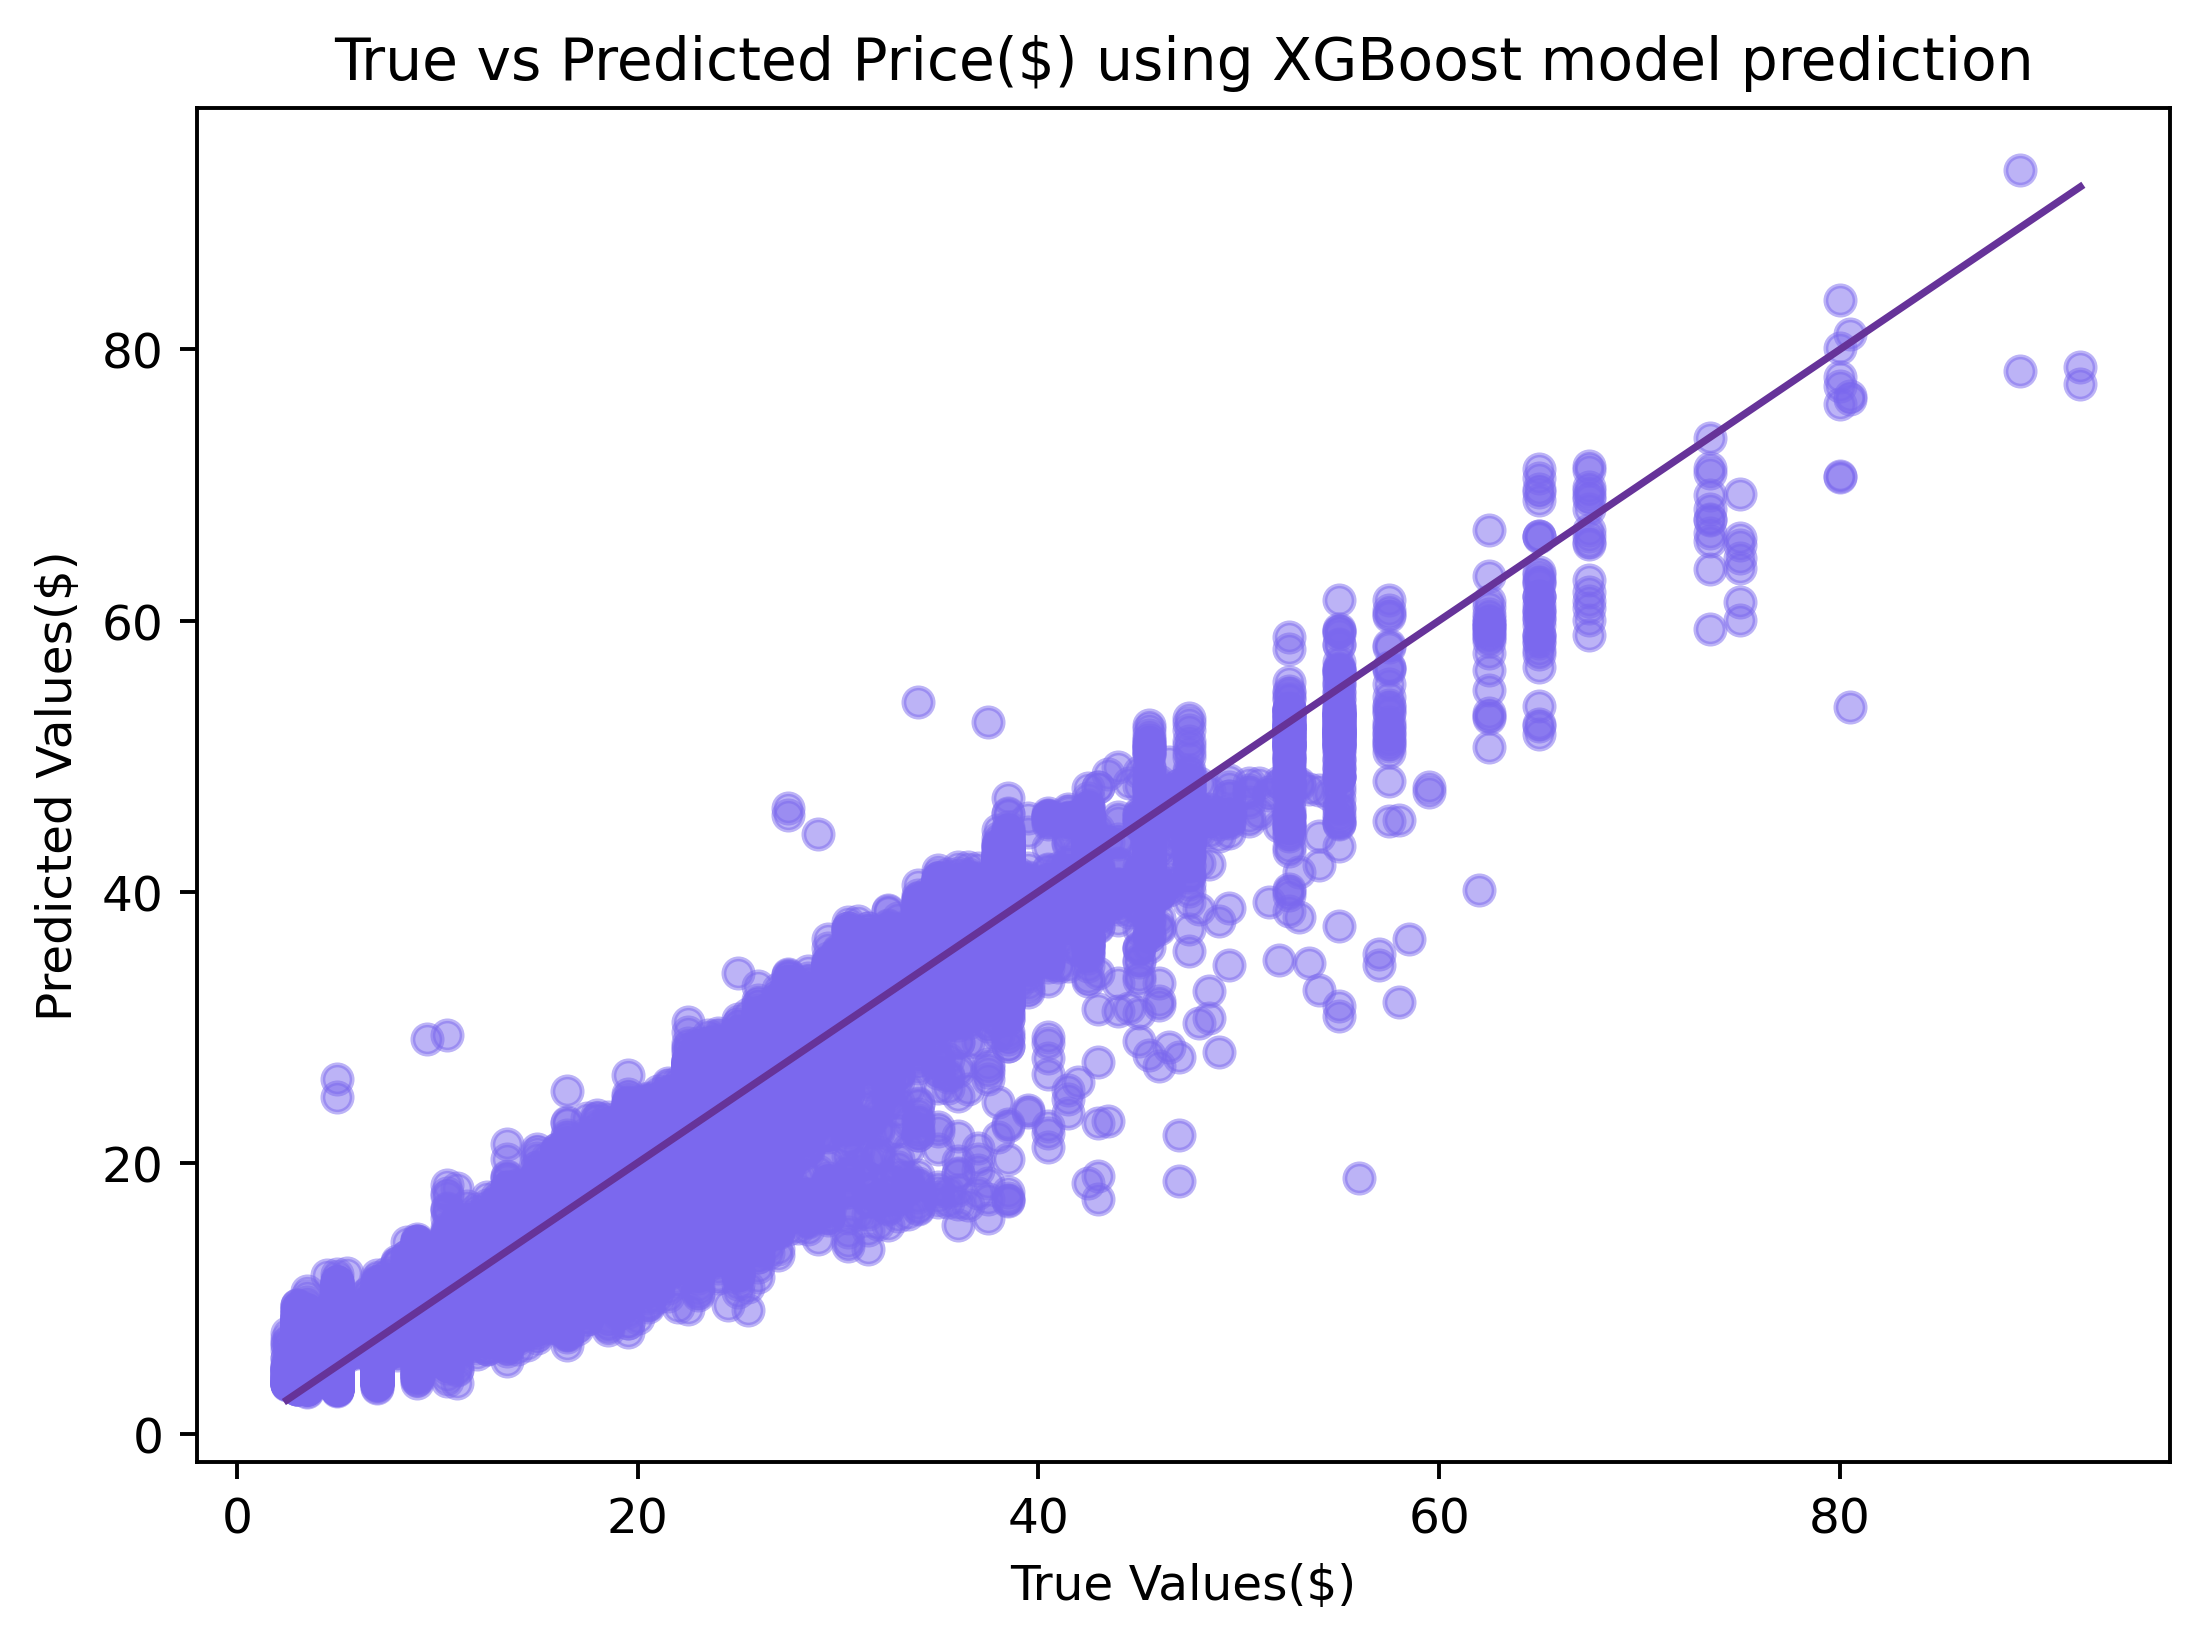

In [52]:
# Calculate the model's error on the test set
y_test_pred = best_models[0].predict(X_test)

# Create a scatter plot
plt.scatter(y_test, y_test_pred, alpha=0.5,color='mediumslateblue')

# Add a line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='rebeccapurple')

# Labeling the plot
plt.title('True vs Predicted Price($) using XGBoost model prediction')
plt.xlabel('True Values($)')
plt.ylabel('Predicted Values($)')
plt.tight_layout()
# Show the plot
plt.show()

In [13]:
y_pred_baseline

(2400, 105)

In [14]:
df_test

num__surge_multiplier  num__distance  num__temperature  num__humidity  \
0                 -0.162747       0.716548         -2.849368      -0.734427   
1                 -0.162747      -1.384645          0.068362      -1.022387   
2                 -0.162747       1.927113          0.112772      -0.734427   
3                  4.729850      -1.047417          0.836653       0.705371   
4                 -0.162747      -1.401939         -0.566699       1.425270   
...                     ...            ...               ...            ...   
2395               2.283551       0.733842          0.568714       1.353281   
2396              -0.162747       0.093972          1.511684       1.353281   
2397              -0.162747       0.690608          0.179387      -0.446467   
2398              -0.162747       0.068032         -0.414225       0.921341   
2399               2.283551      -1.384645          0.182348      -0.734427   

      num__windSpeed  num__visibility  num__pressure  num__cloudCover  \
0          -0.846052         0.559466       1.632917        -0.883127   
1          -0.877627         0.527251       0.518184         0.868936   
2           0.922111         0.591298      -1.133796         0.868936   
3           0.227475         0.591298       0.021174         0.868936   
4           0.745294        -1.860919      -0.409518         0.868936   
...              ...              ...            ...              ...   
2395       -1.082860        -0.896370       0.363195         0.868936   
2396       -0.877627        -2.073388      -0.437833         0.868936   
2397        0.647414         0.591298      -1.409499        -1.133421   
2398        0.126437         0.433289      -0.516818         0.868936   
2399       -0.899729         0.543742       1.723079        -1.912116   

      num__moonPhase  num__precipIntensityMax  ...  cat__name_Lux  \
0          -1.511564                -0.683313  ...            0.0   
1           0.857719                -0.679704  ...            0.0   
2           0.571771                -0.685118  ...            0.0   
3           0.244973                 1.529498  ...            0.0   
4          -1.021367                -0.351211  ...            0.0   
...              ...                      ...  ...            ...   
2395        0.244973                 1.661256  ...            0.0   
2396        1.143667                 0.968173  ...            0.0   
2397        0.408372                 1.881455  ...            0.0   
2398       -1.021367                -0.369260  ...            0.0   
2399       -1.389015                -0.685118  ...            1.0   

      cat__name_Lux Black  cat__name_Lux Black XL  cat__name_Lyft  \
0                     0.0                     0.0             0.0   
1                     0.0                     0.0             0.0   
2                     0.0                     0.0             0.0   
3                     0.0                     0.0             1.0   
4                     0.0                     0.0             0.0   
...                   ...                     ...             ...   
2395                  0.0                     1.0             0.0   
2396                  0.0                     0.0             0.0   
2397                  0.0                     0.0             0.0   
2398                  0.0                     0.0             0.0   
2399                  0.0                     0.0             0.0   

      cat__name_Lyft XL  cat__name_Shared  cat__name_UberPool  \
0                   1.0               0.0                 0.0   
1                   0.0               0.0                 0.0   
2                   0.0               0.0                 0.0   
3                   0.0               0.0                 0.0   
4                   0.0               1.0                 0.0   
...                 ...               ...                 ...   
2395                0.0               0.0                 0.0   
23

In [32]:
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

# Sample indices
sample_indices1 = pd.Series(range(len(y_train))).sample(n=20000, random_state=42)
sample_indices2 = pd.Series(range(len(y_CV))).sample(n=10000, random_state=42)
sample_indices3 = pd.Series(range(len(y_test))).sample(n=10000, random_state=42)
# Sample features and labels using the same indices
df_train = pd.DataFrame(data=X_prep, columns=feature_names).iloc[sample_indices1]
y_train_sampled = y_train.iloc[sample_indices1]
print(f'preprocessed train size: {df_train.shape}')

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names).iloc[sample_indices2]
print(f'preprocessed validation size: {df_CV.shape}')
y_CV_sampled = y_CV.iloc[sample_indices2]

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names).iloc[sample_indices3]
print(f'preprocessed test size: {df_test.shape}')
y_test_sampled = y_test.iloc[sample_indices3]

preprocessed train size: (20000, 105)
preprocessed validation size: (10000, 105)
preprocessed test size: (10000, 105)


In [ ]:
# Combine all model results into one list of dictionaries
all_results = []
for model_result in [ ridge_results,ElasticNet_results,rf_results,xgb_results]:  # Add all your model result variables here
    for i in range(len(model_result['test_rmse'])):  # Assuming each list in the dictionary is of the same length
        all_results.append({
            'model': model_result['model'],
            'test_rmse': model_result['test_rmse'][i],
            'test_r2': model_result['test_r2'][i]
        })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

In [52]:
import pandas as pd

# Example data (replace with your actual data)
data = {
    'Model': ['XGBoost', 'Ridge', 'ElasticNet', 'RandomForest'],
    'Mean_RMSE': [
        xgb_results['mean_test_rmse_score'], 
        ridge_results['mean_test_rmse_score'], 
        ElasticNet_results['mean_test_rmse_score'], 
        rf_results['mean_test_rmse_score']
    ],
    'Std_RMSE': [
        xgb_results['std_test_rmse_score'], 
        ridge_results['std_test_rmse_score'], 
        ElasticNet_results['std_test_rmse_score'], 
        rf_results['std_test_rmse_score']
    ],
    'Mean_R2': [
        xgb_results['mean_test_r2_score'], 
        ridge_results['mean_test_r2_score'], 
        ElasticNet_results['mean_test_r2_score'], 
        rf_results['mean_test_r2_score']
    ],
    'Std_R2': [
        xgb_results['std_test_r2_score'], 
        ridge_results['std_test_r2_score'], 
        ElasticNet_results['std_test_r2_score'], 
        rf_results['std_test_r2_score']
    ]
}

df = pd.DataFrame(data)


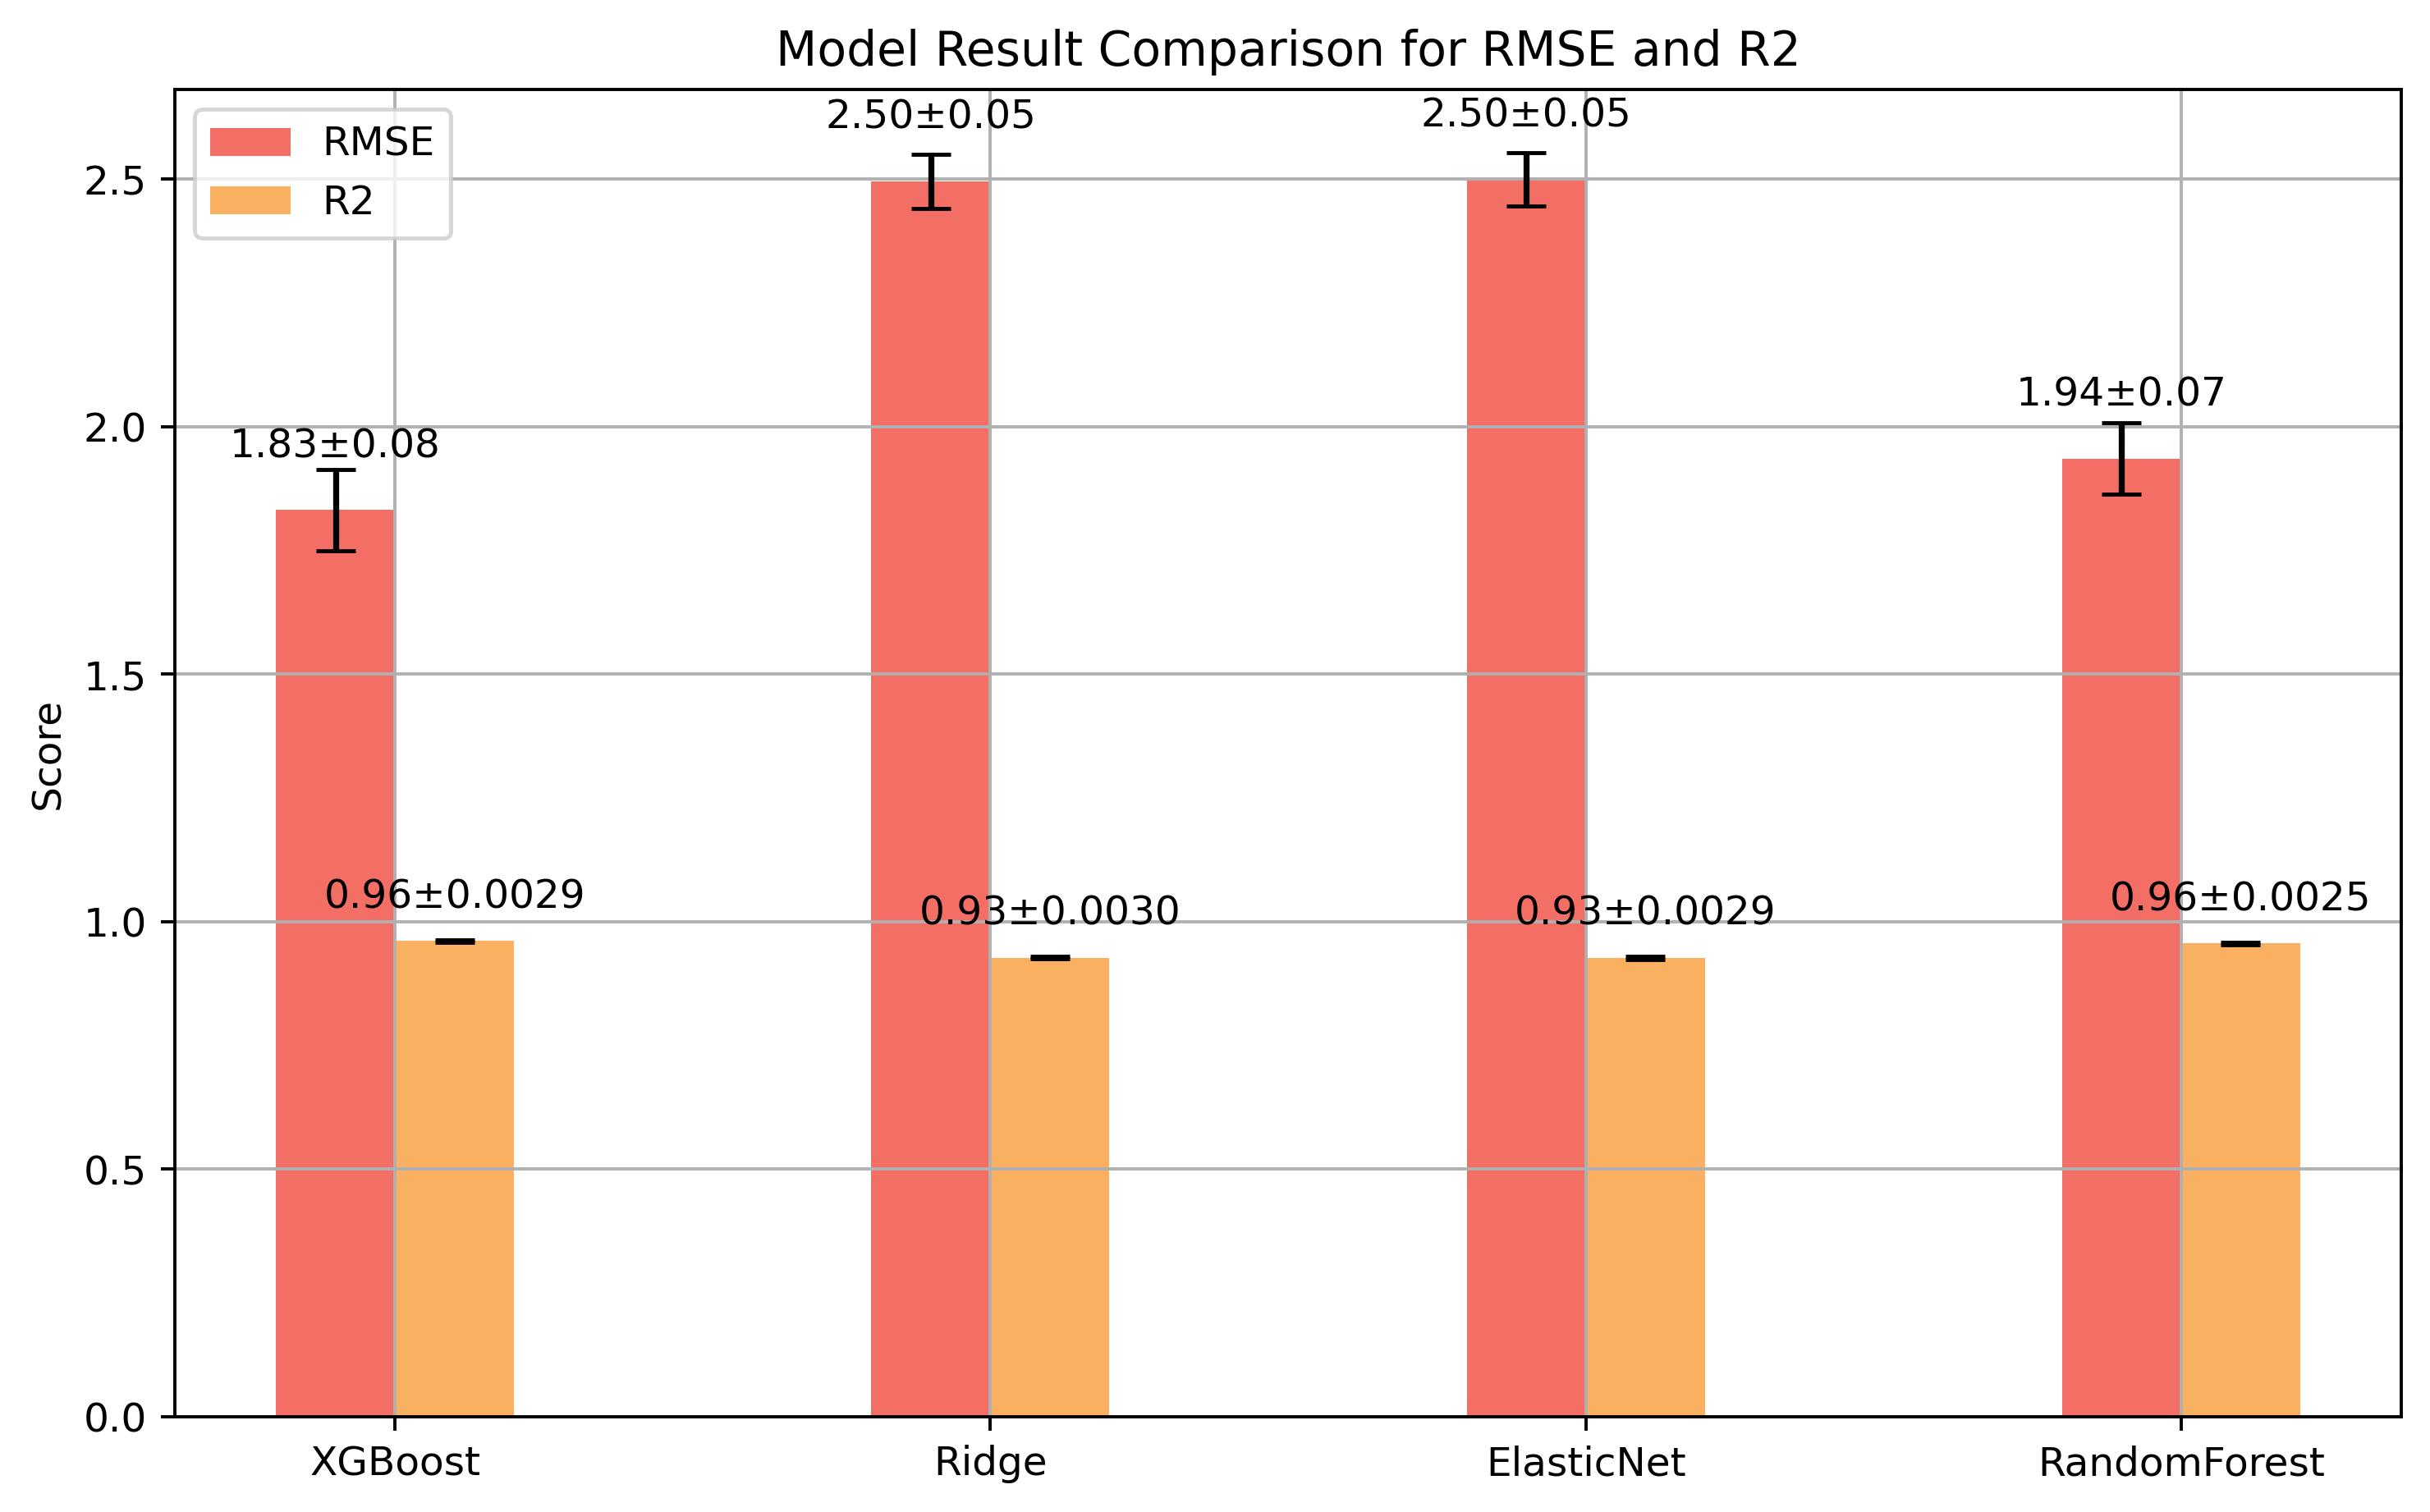

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Setting the positions and width for the bars
pos = list(range(len(df['Model'])))
width = 0.2 

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for RMSE
rmse_bars = plt.bar(pos, df['Mean_RMSE'], width, alpha=0.7, color='#EE3224', yerr=df['Std_RMSE'], capsize=5, label='RMSE')

# Create bars for R2
r2_bars = plt.bar([p + width for p in pos], df['Mean_R2'], width, alpha=0.7, color='#F78F1E', yerr=df['Std_R2'], capsize=5, label='R2')

# Set the y axis label
ax.set_ylabel('Score')

# Set the chart's title
ax.set_title('Model Result Comparison for RMSE and R2')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['Model'])

# Text annotations for RMSE
for idx, bar in enumerate(rmse_bars):
    mean = df['Mean_RMSE'][idx]
    std = df['Std_RMSE'][idx]
    text = f'{mean:.2f}±{std:.2f}'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.09, text, ha='center', va='bottom')

# Text annotations for R2
for idx, bar in enumerate(r2_bars):
    mean = df['Mean_R2'][idx]
    std = df['Std_R2'][idx]
    text = f'{mean:.2f}±{std:.4f}'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.05, text, ha='center', va='bottom')

# Adding the legend and showing the plot
plt.legend(['RMSE', 'R2'], loc='upper left')
plt.grid()
plt.savefig(f"./Figures/model_result.png")
plt.show()


the CV RMSE: 1.833214569174307
the test RMSE: 1.6943122070946017
the test R2: 0.9666825114300448


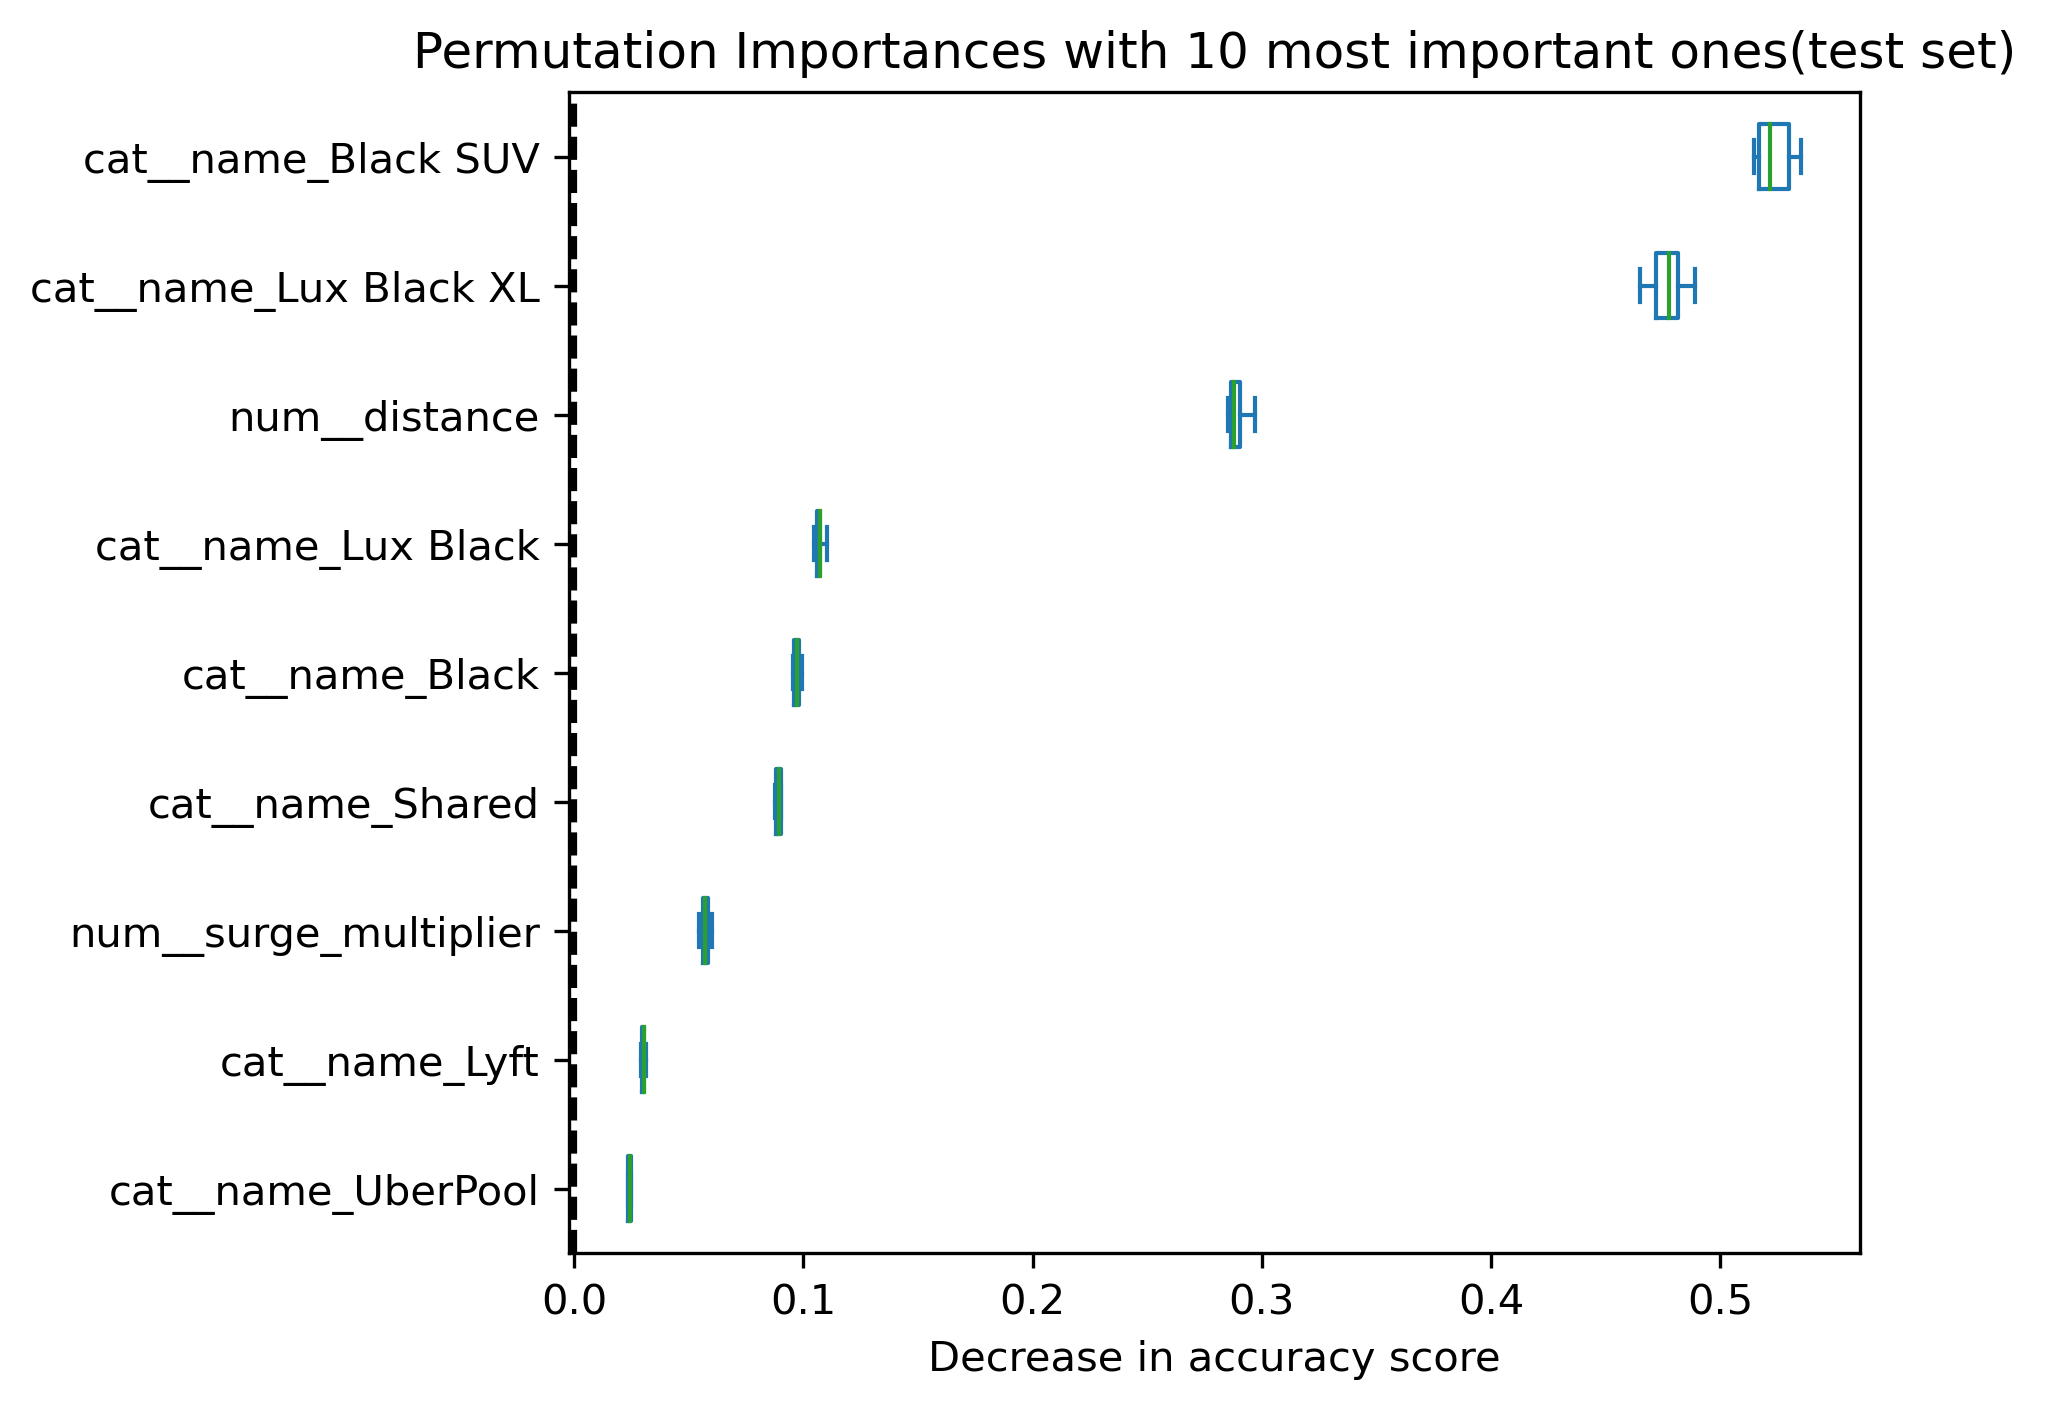

In [60]:
from sklearn.inspection import permutation_importance
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# parameters to try 
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

# create xgboost model and set parameters 
XGB = xgboost.XGBRegressor(early_stopping_rounds=50)
XGB.set_params(**ParameterGrid(param_grid)[0])

# fit model to train data 
XGB.fit(df_train,y_train_sampled,eval_set=[(df_CV, y_CV_sampled)], verbose=False)

# predict on validation 
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV_sampled,y_CV_pred)))

# predict on test 
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test_sampled,y_test_pred)))
print('the test R2:',r2_score(y_test_sampled,y_test_pred))

result = permutation_importance(
    XGB, df_test, y_test_sampled, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx[-9:]].T,
    columns=df_test.columns[sorted_importances_idx[-9:]],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances with 10 most important ones(test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.set_dpi(300)
plt.savefig(f"./Figures/permutation_importances")
ax.figure.tight_layout()

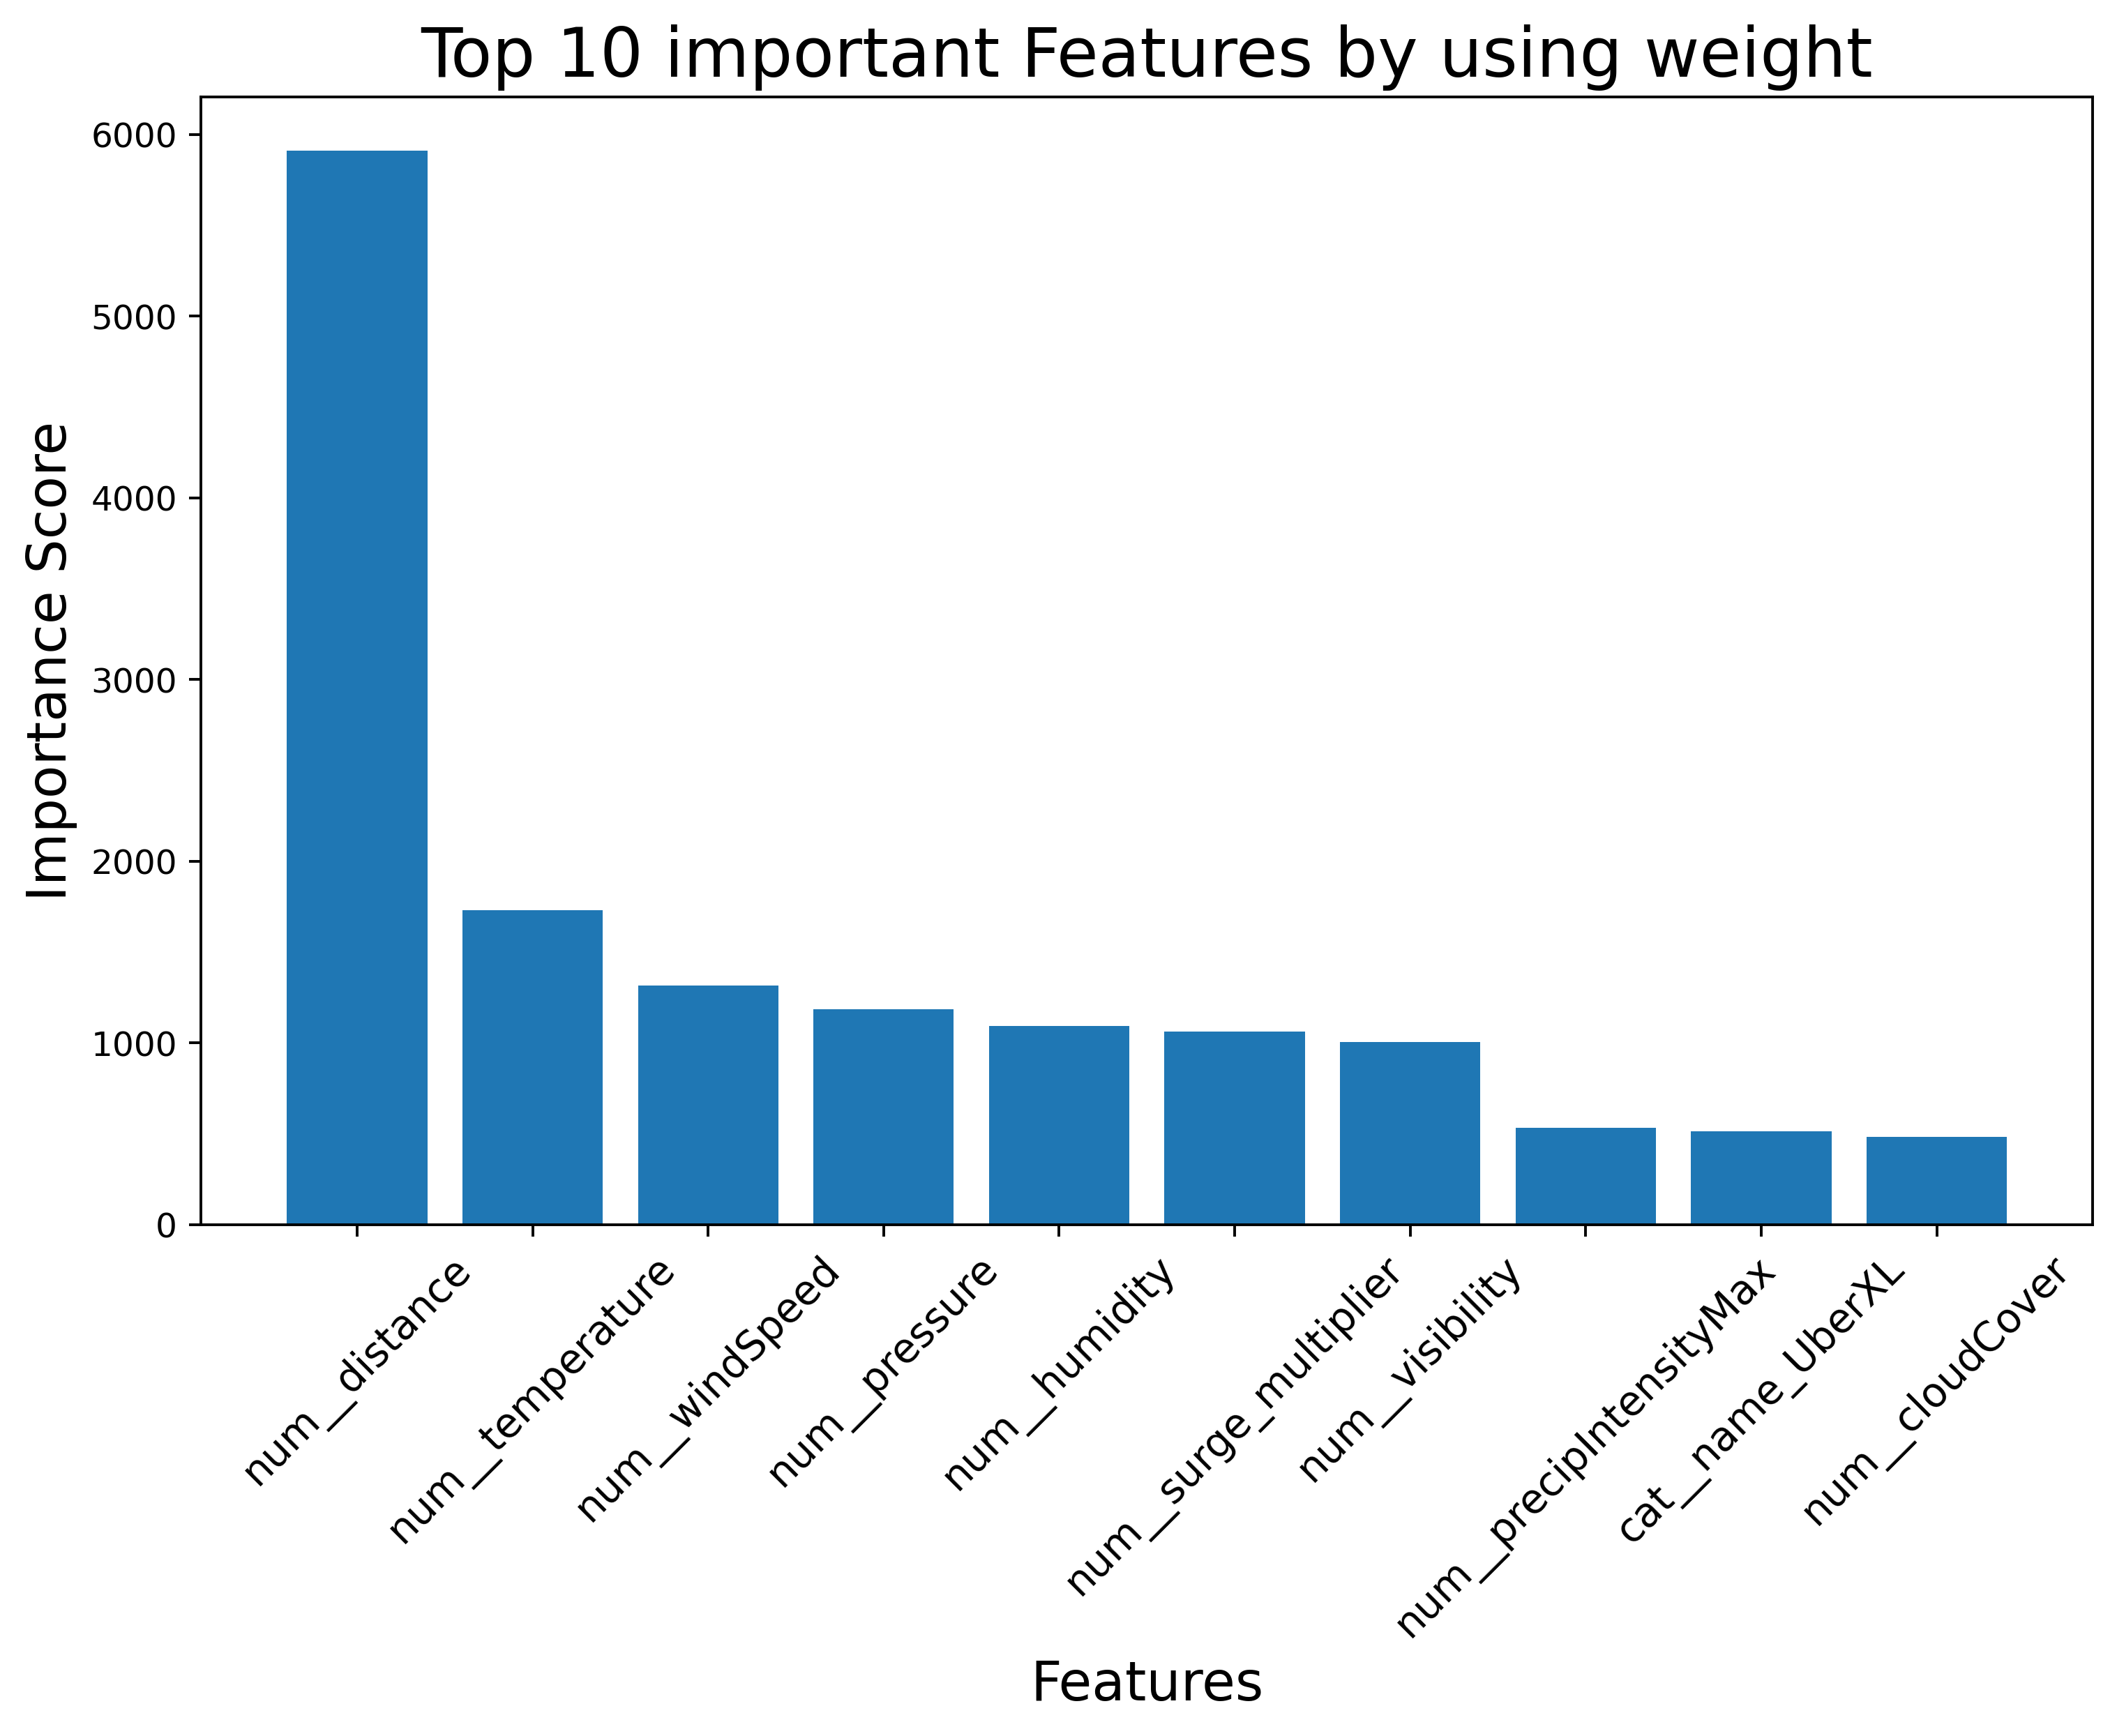

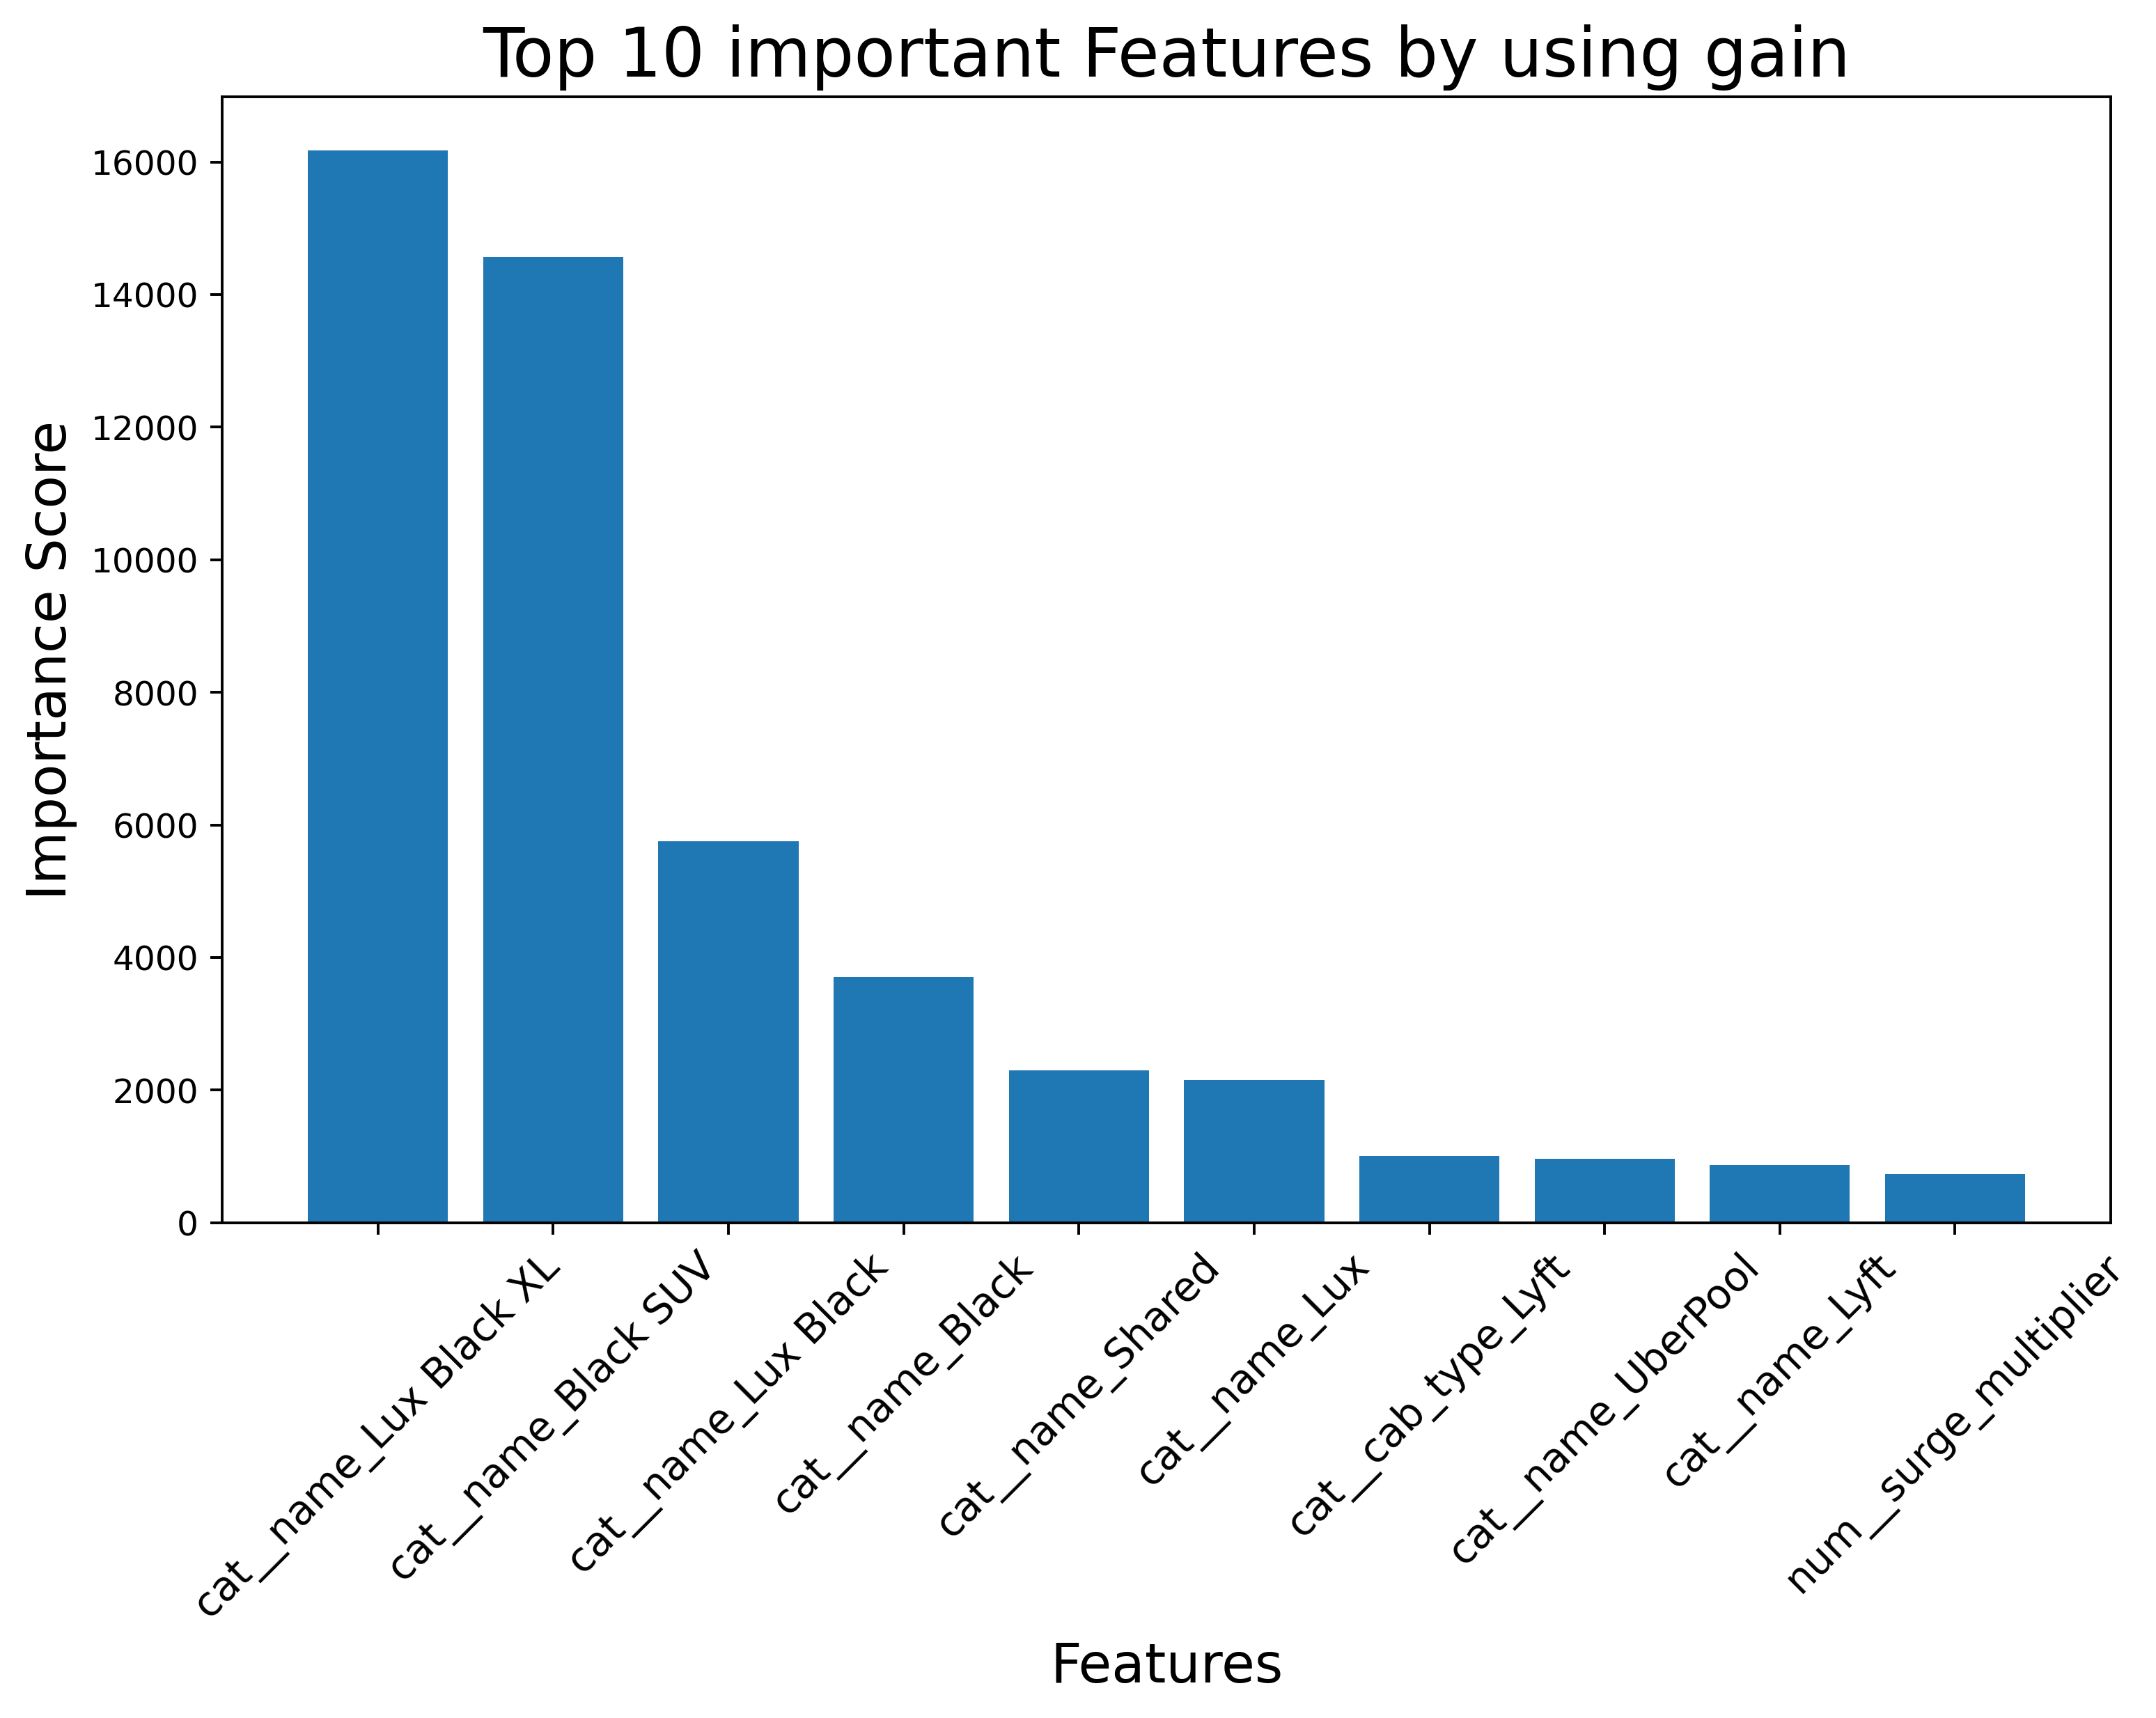

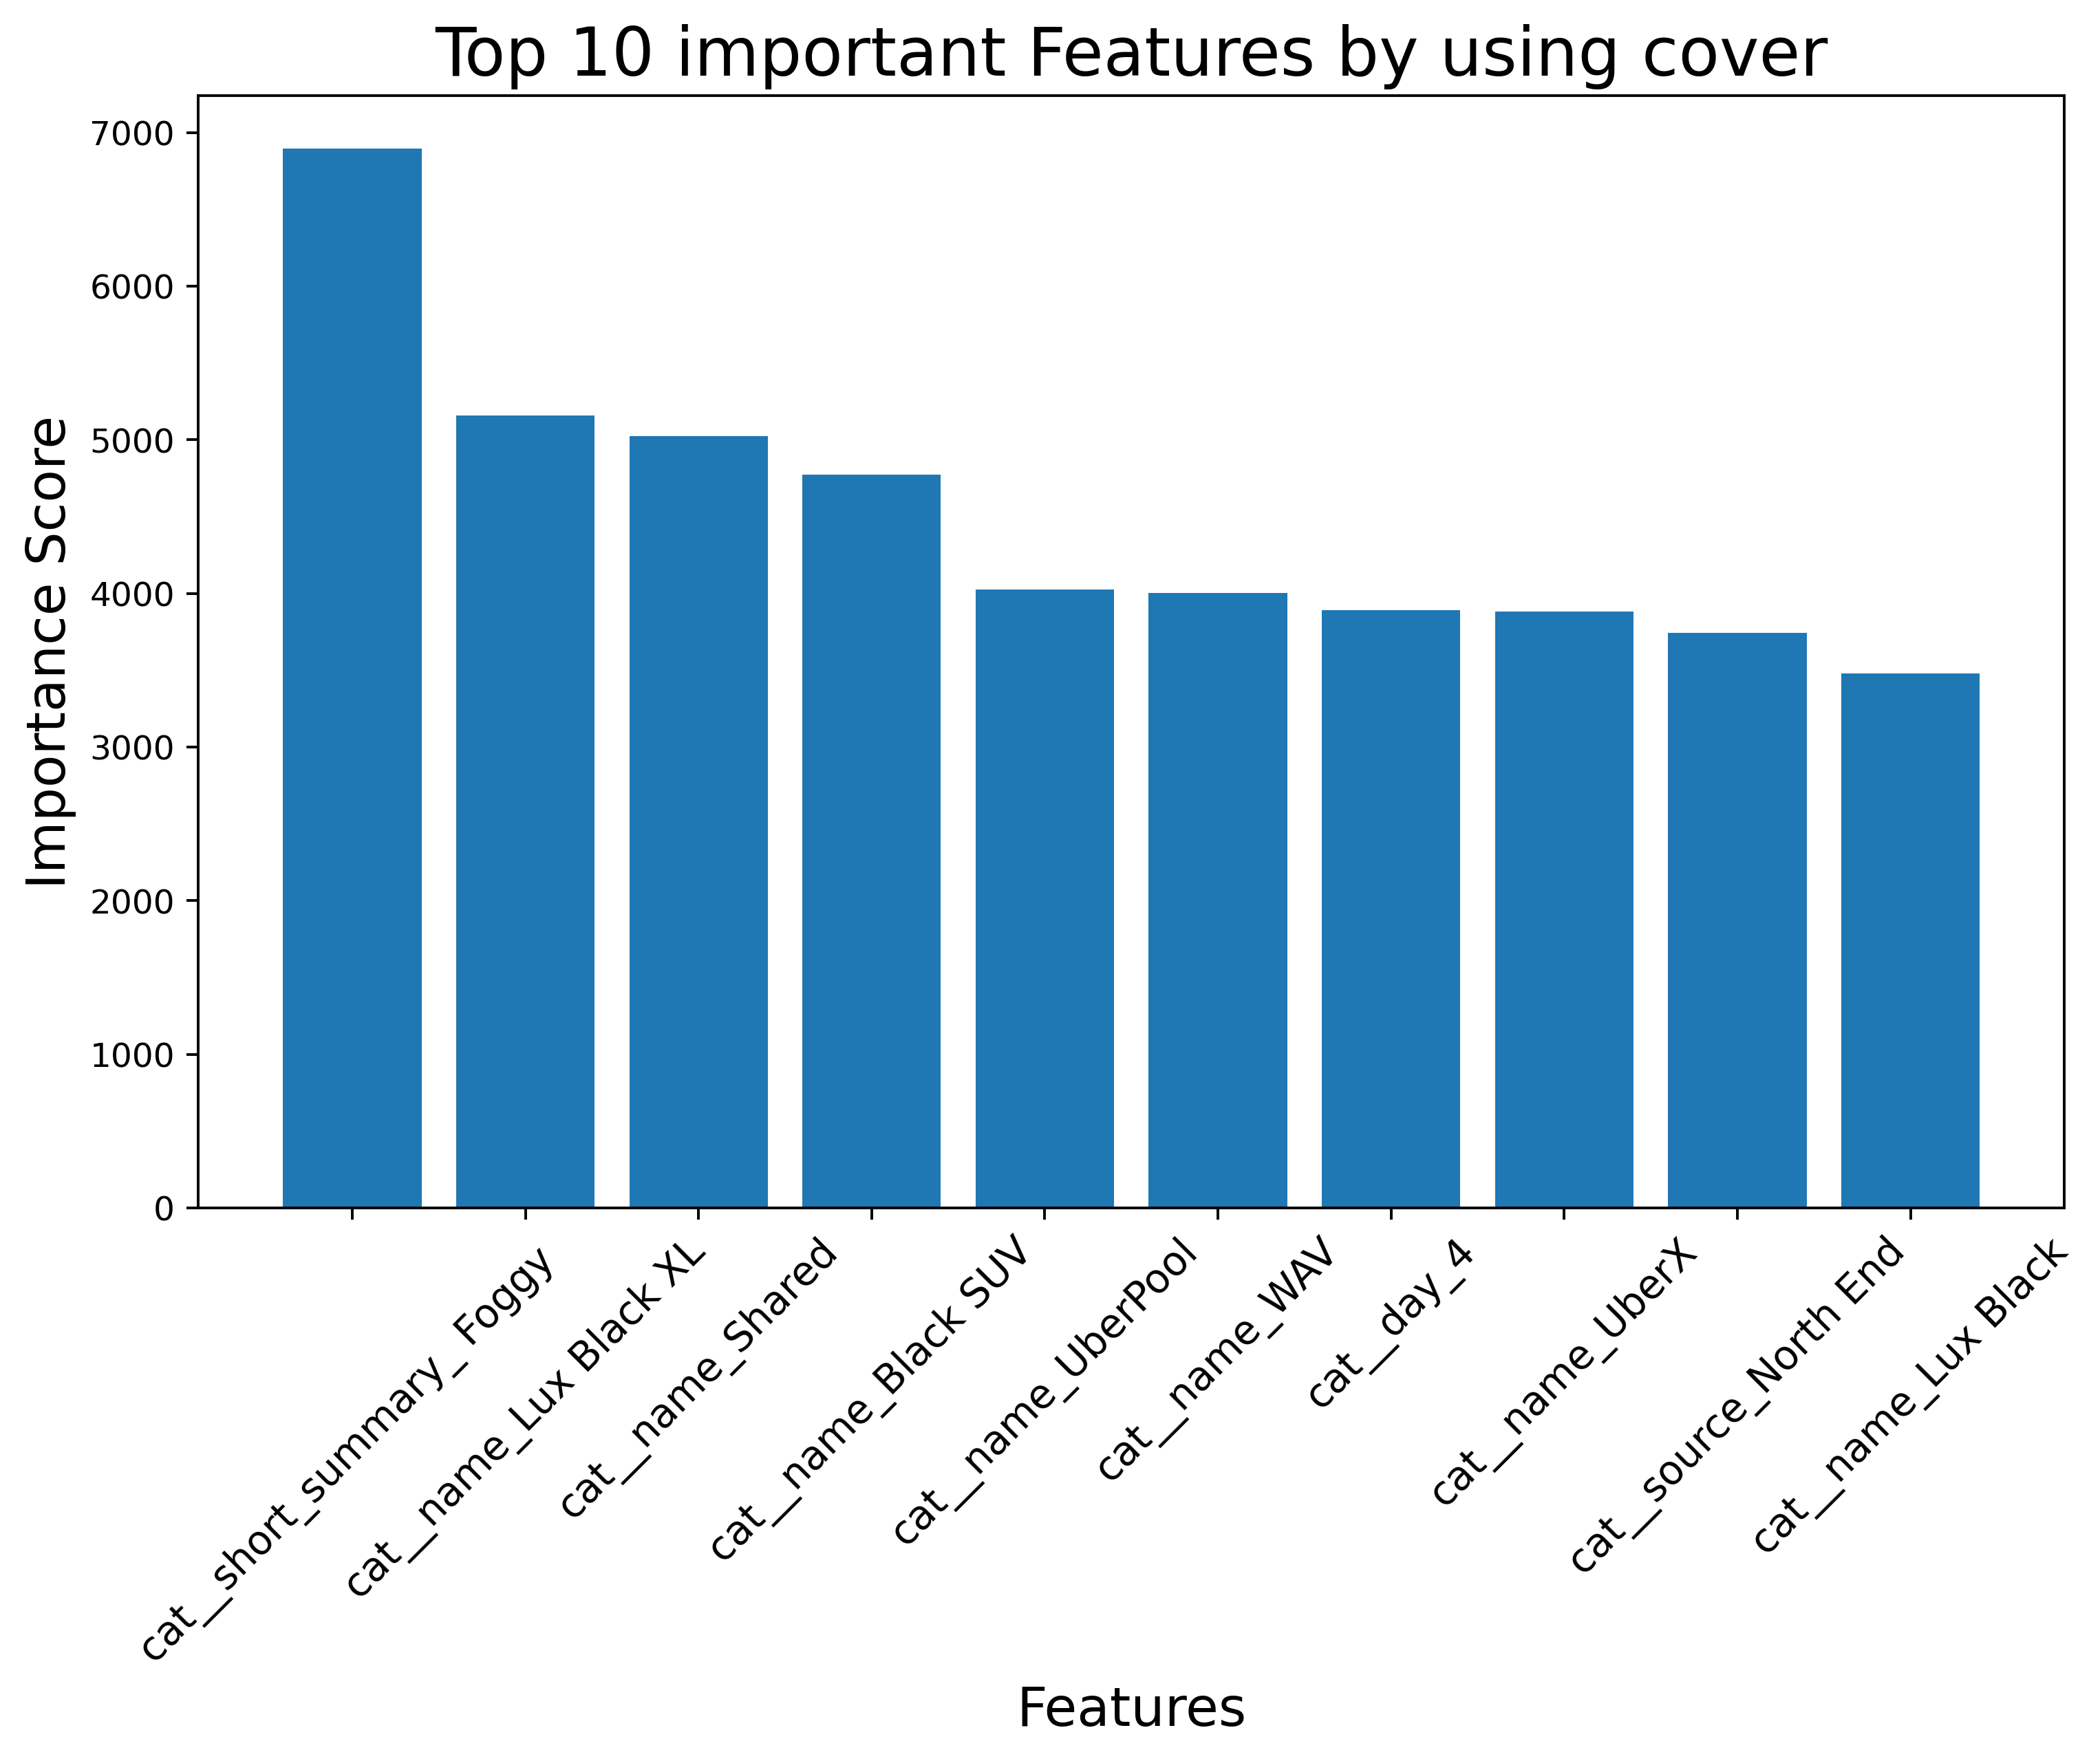

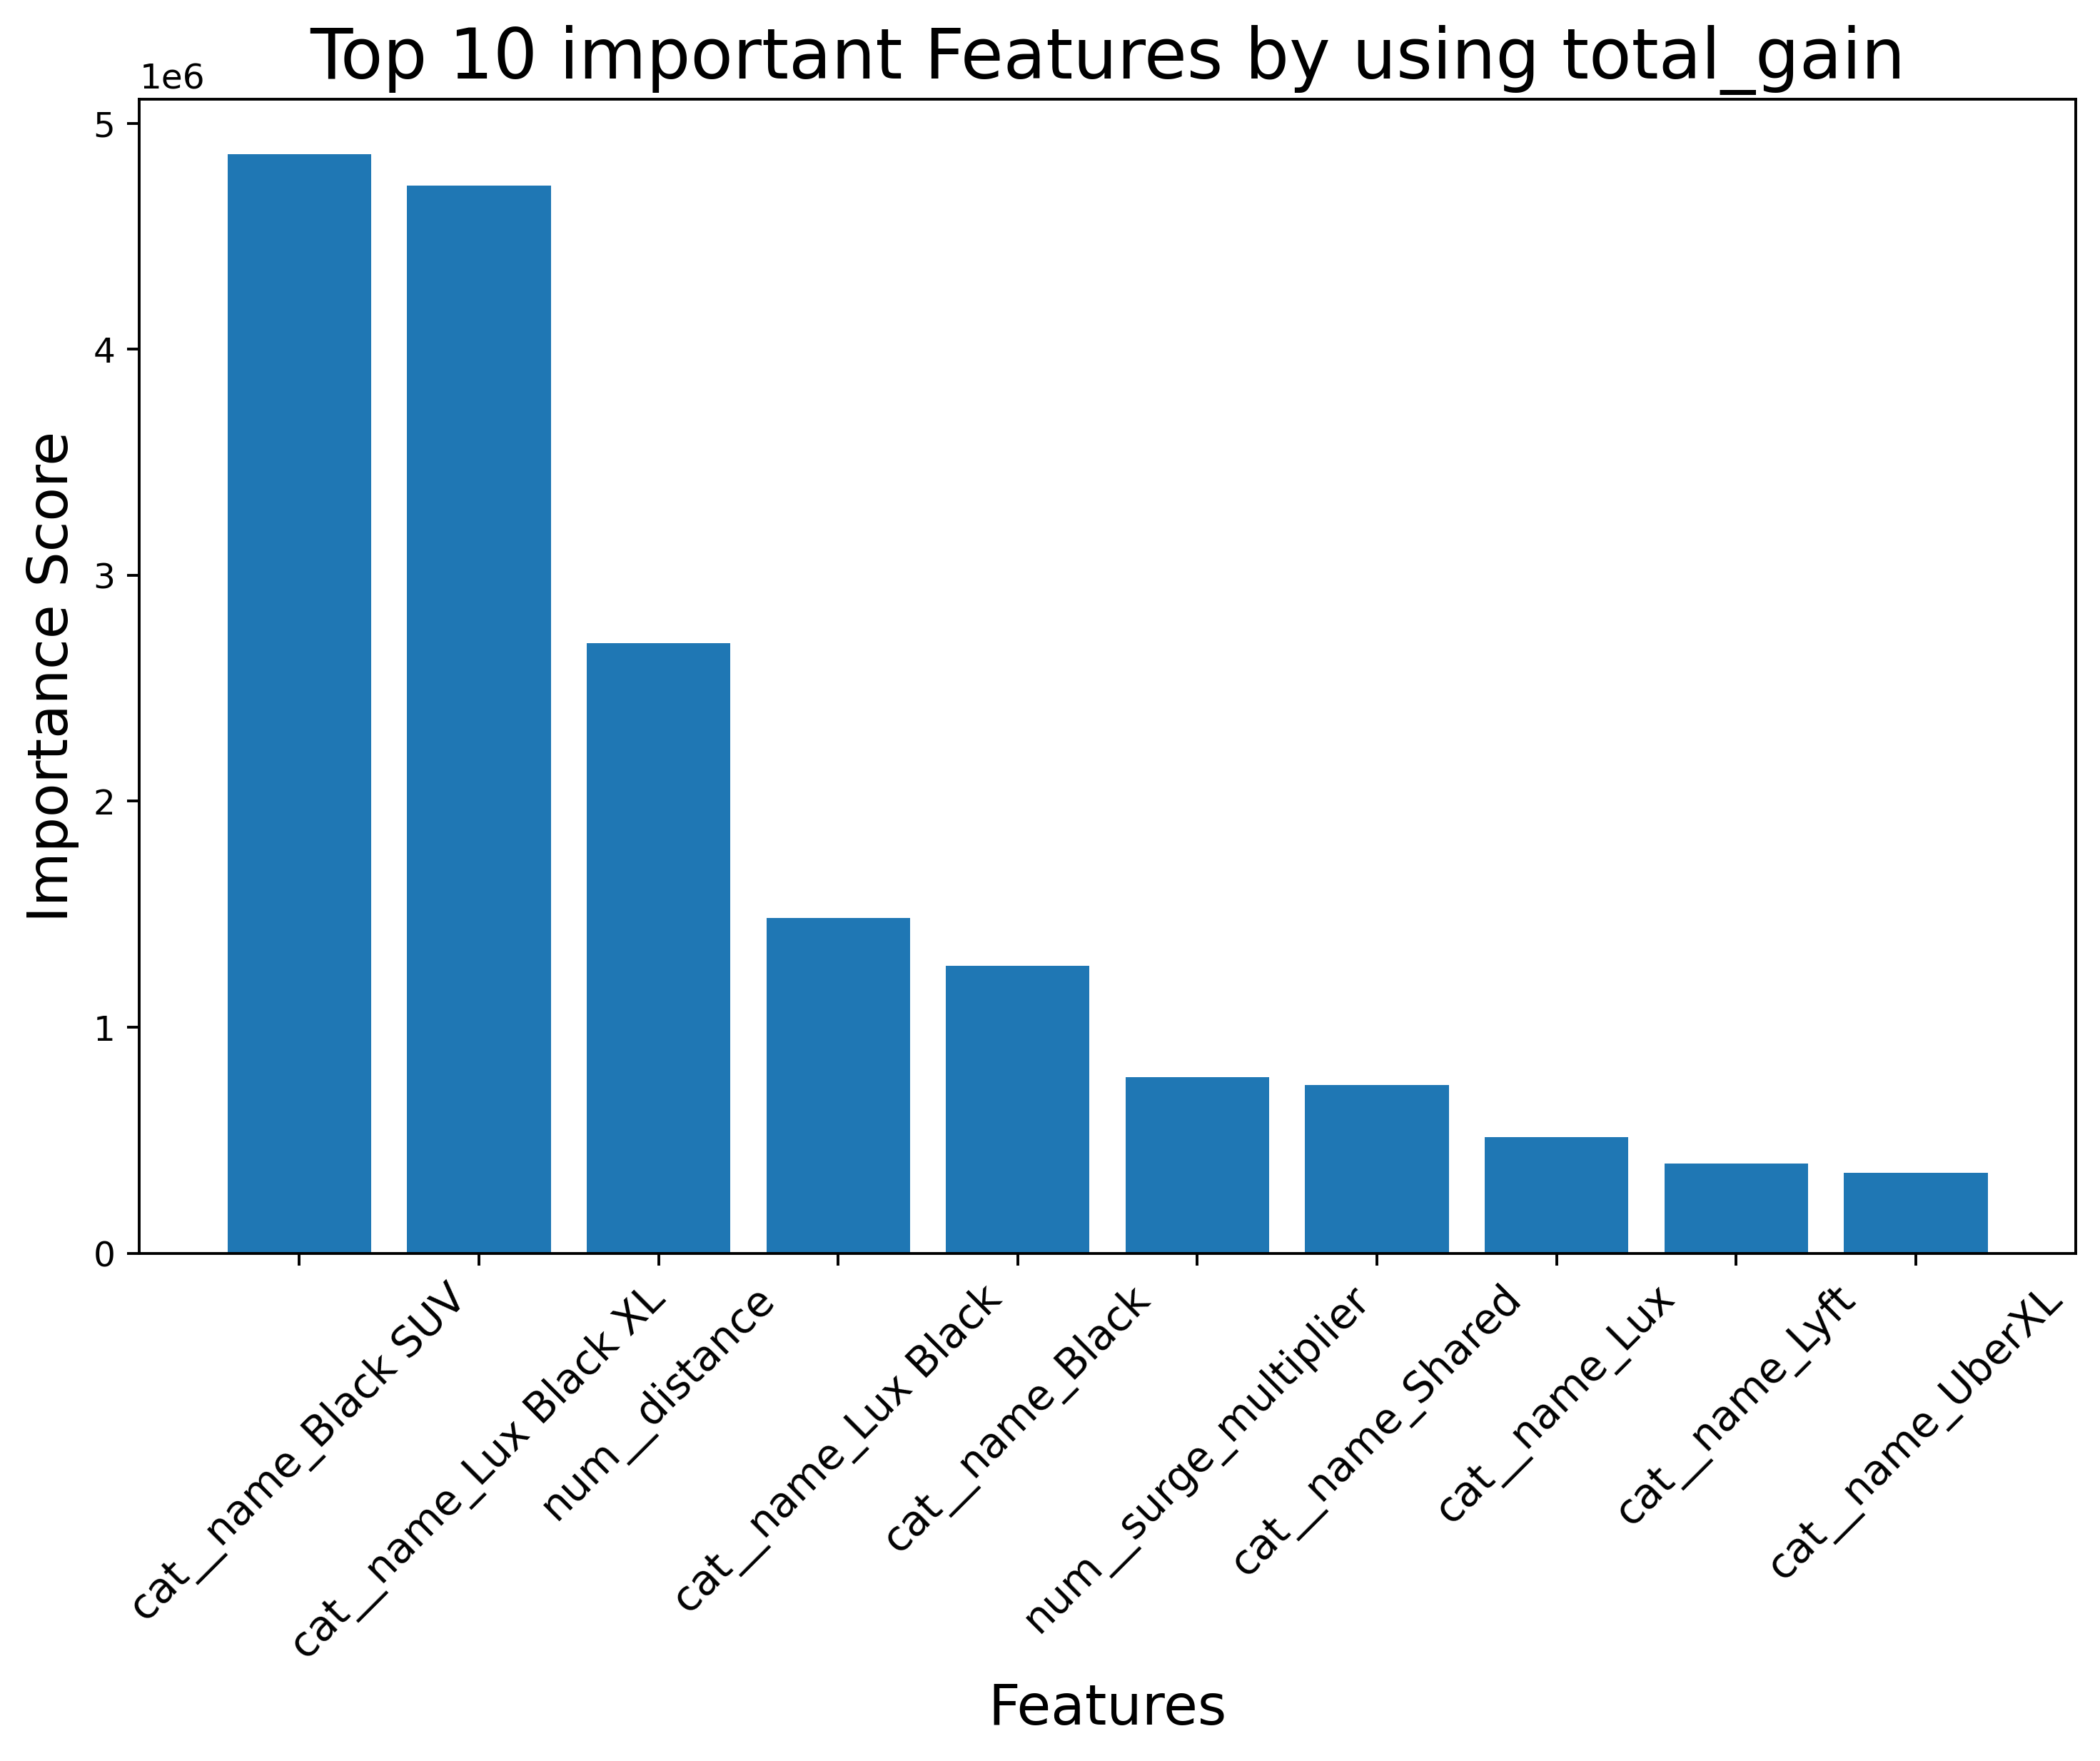

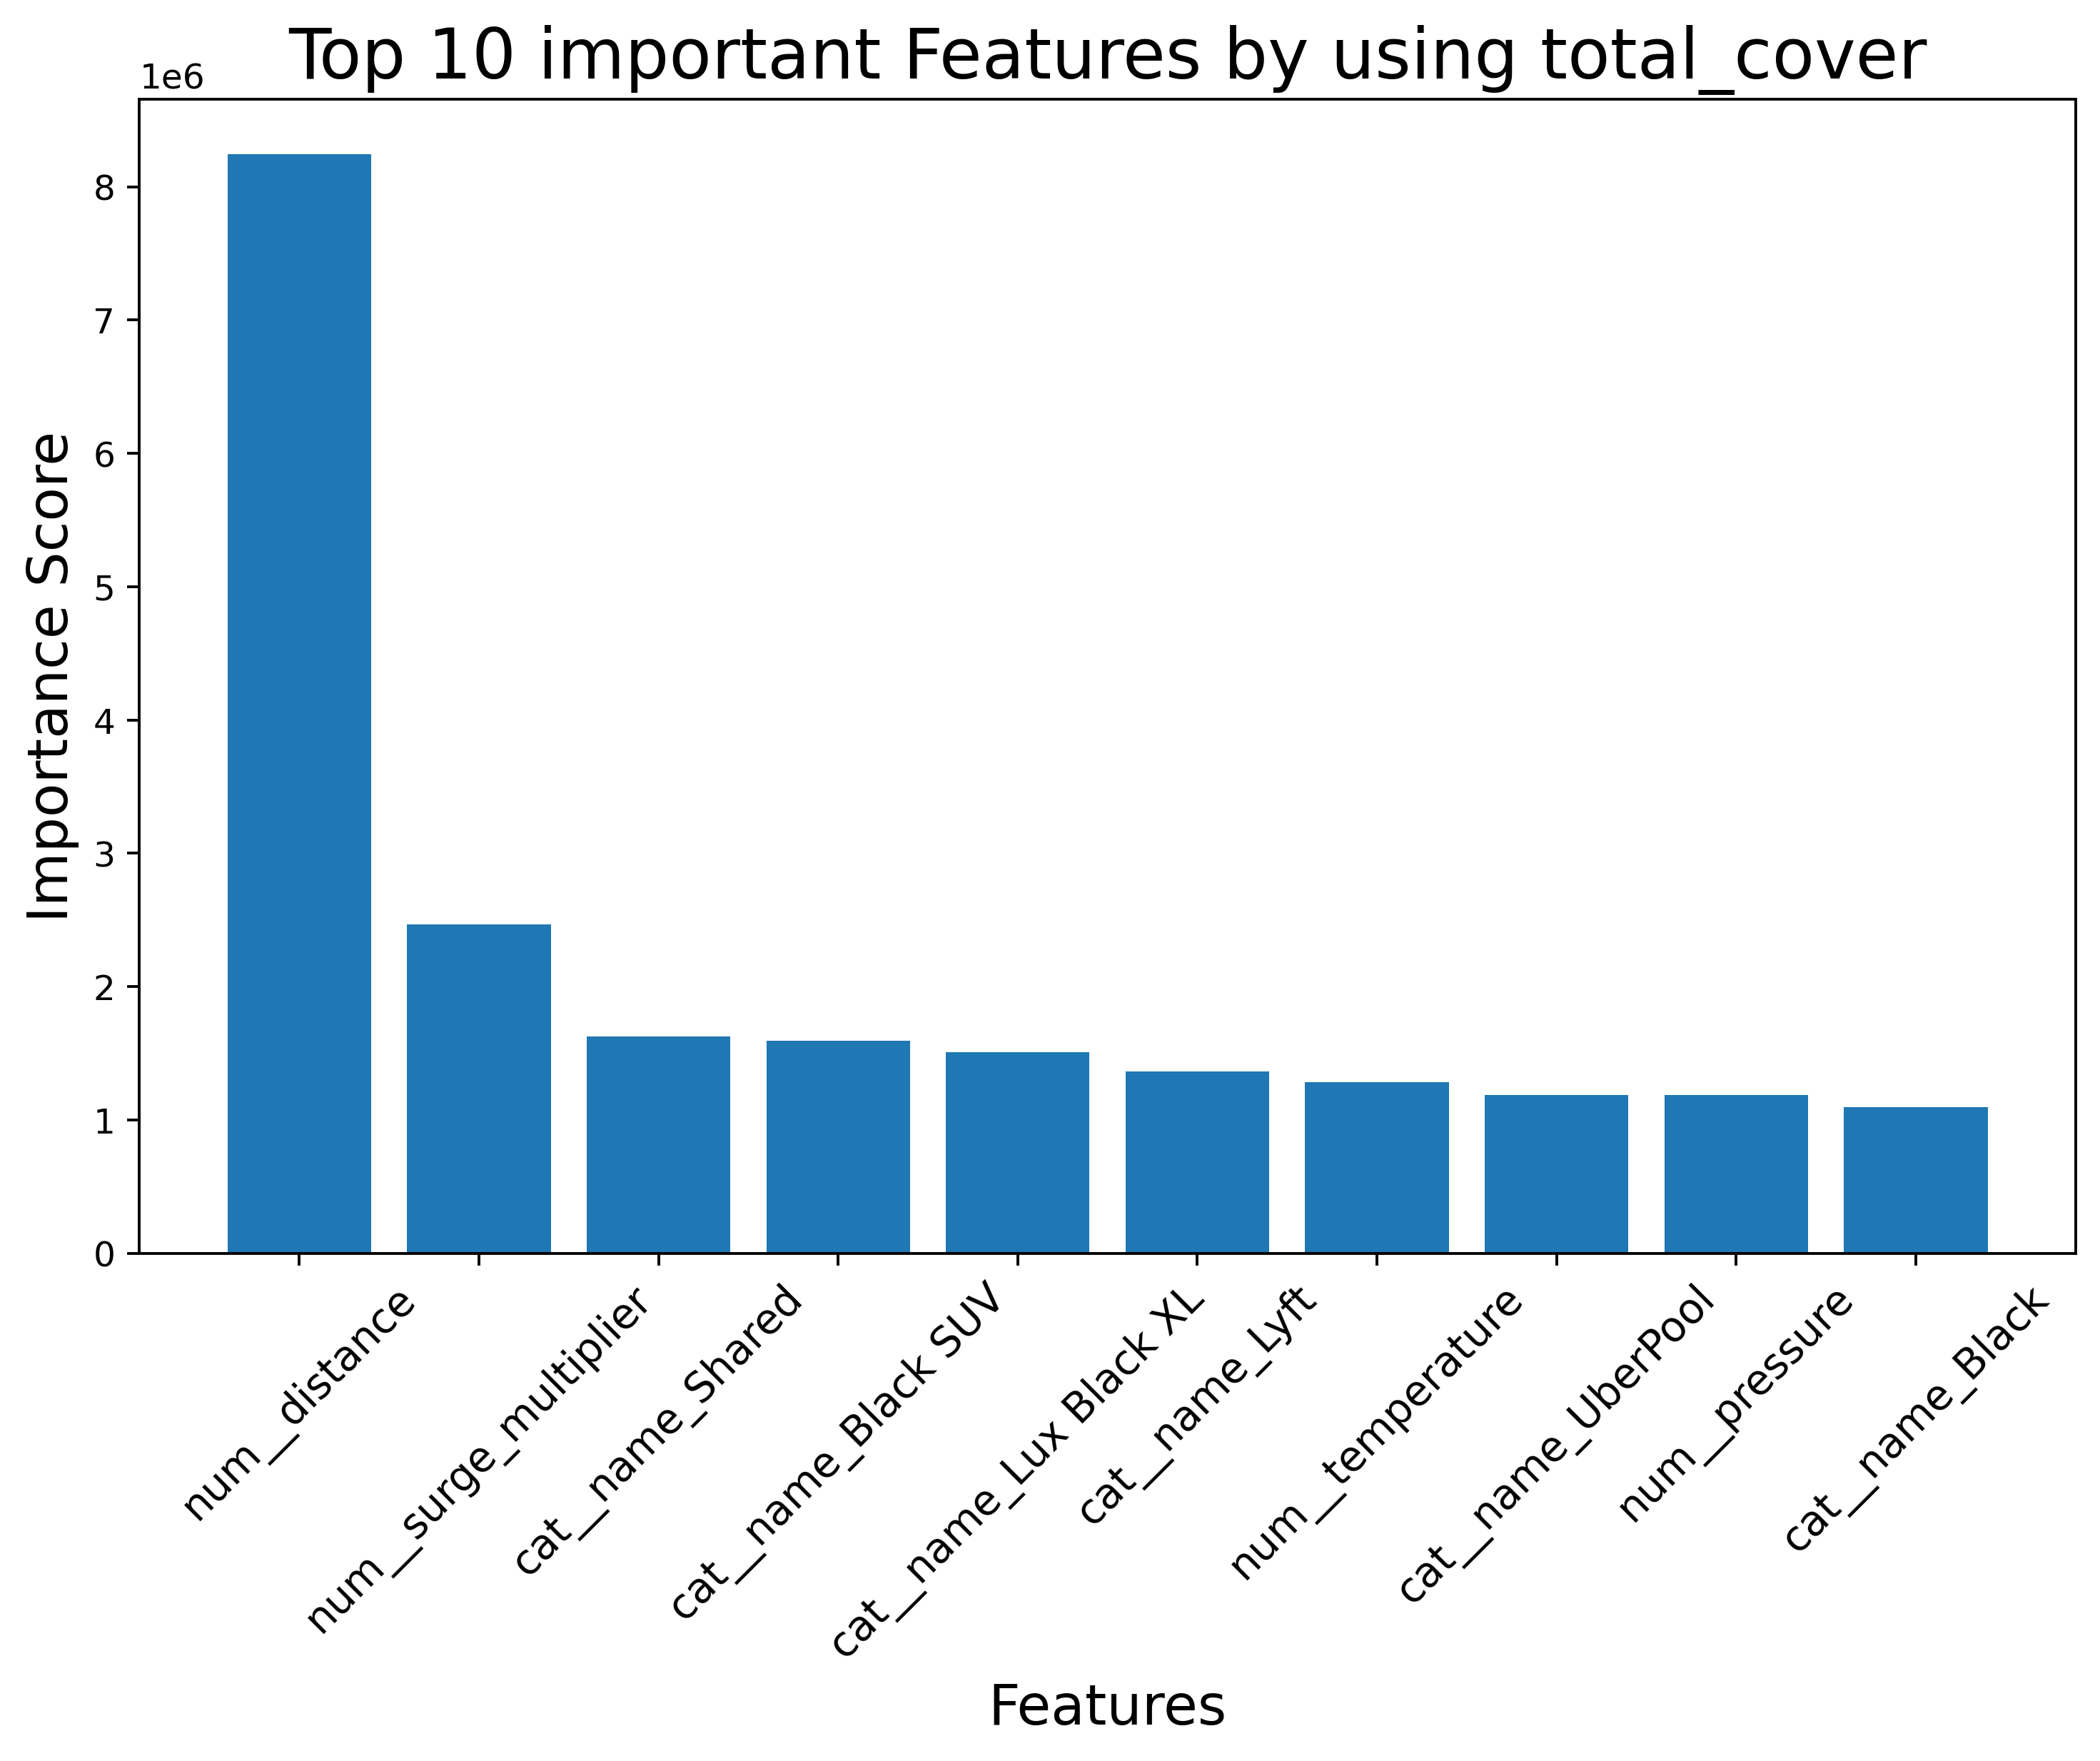

In [58]:
booster = XGB.get_booster()
# List of importance types
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for f in importance_types:
    # Get feature importance
    importance = booster.get_score(importance_type=f)
    
    # Sort and get top 10 features
    top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
    top_features_dict = dict(top_features)

    # Plotting
    plt.figure(figsize=(10, 6), dpi=350)
    plt.title(f'Top 10 important Features by using {f}',fontsize=20)
    bars = plt.bar(range(len(top_features_dict)), list(top_features_dict.values()), align='center')
    plt.xticks(range(len(top_features_dict)), list(top_features_dict.keys()), rotation=45,fontsize=12)
    # Adding x-axis and y-axis labels
    plt.xlabel('Features',fontsize=16)
    plt.ylabel('Importance Score',fontsize=16)
    plt.savefig(f"./Figures/xgboost_global_importance_{f}")

    plt.show()

In [25]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.3/450.3 kB 6.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


[21:08:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


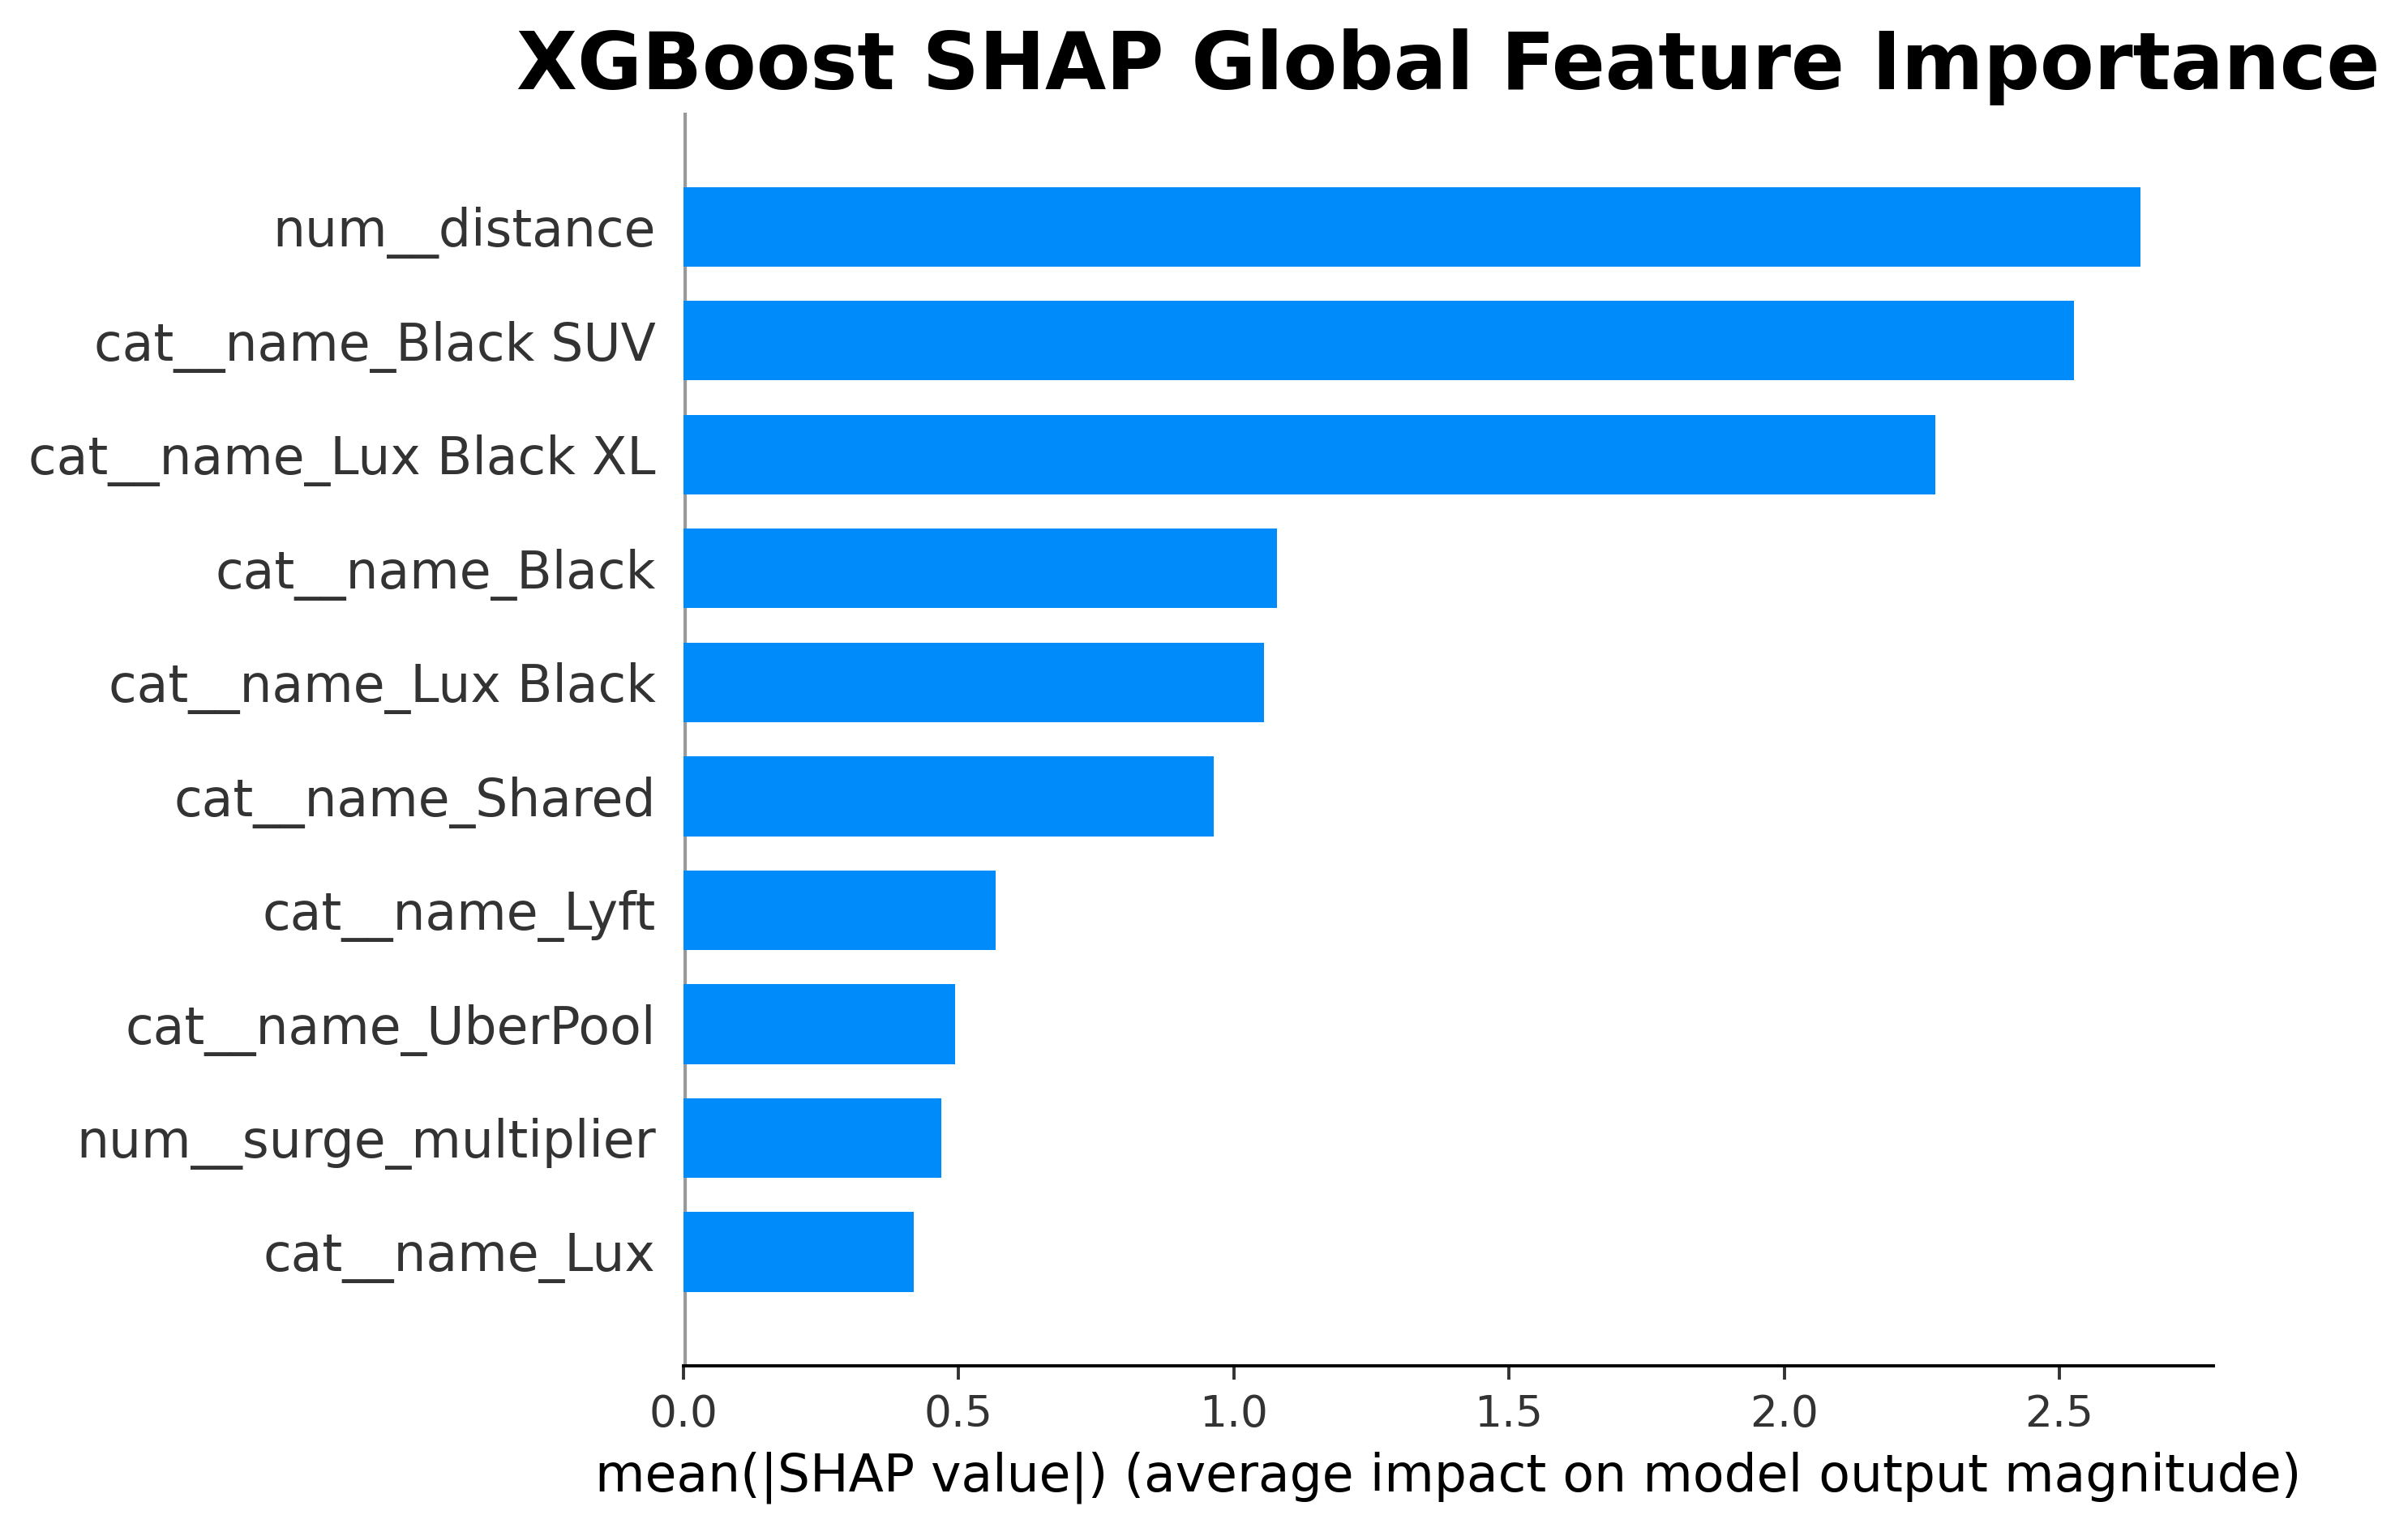

<Figure size 2240x1680 with 0 Axes>

In [57]:
import shap
import pandas as pd
plt.rcParams['figure.dpi'] = 350  
# Initialize SHAP


# Create object that can calculate shap values
explainer = shap.TreeExplainer(XGB)

# Calculate SHAP values on the encoded test data
shap_values = explainer.shap_values(df_test)

# Feature names after encoding
feature_names_encoded = df_test.columns

# Global feature importance plot
plt.gcf().set_size_inches(10, 5)
plt.title('XGBoost SHAP Global Feature Importance', fontweight='bold',fontsize=20)
shap.summary_plot(shap_values, df_test, feature_names=feature_names_encoded, plot_type="bar", max_display=10)
plt.savefig(f"./Figures/shap_global_importance")
plt.show()

<Figure size 3500x1050 with 0 Axes>

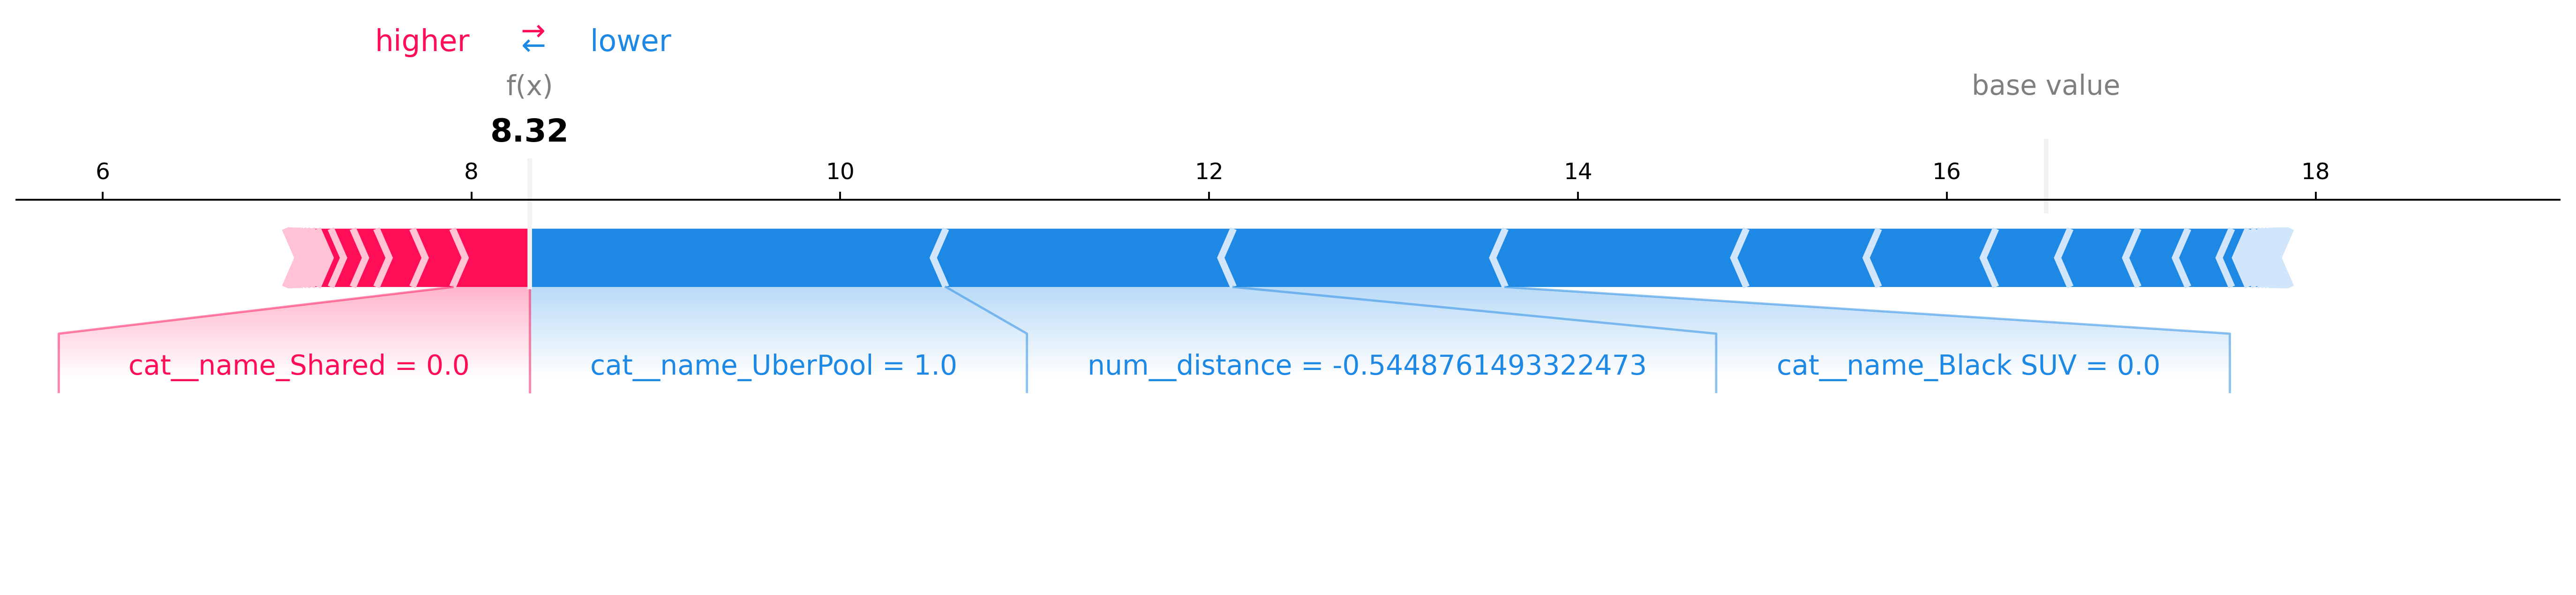

<Figure size 3500x1050 with 0 Axes>

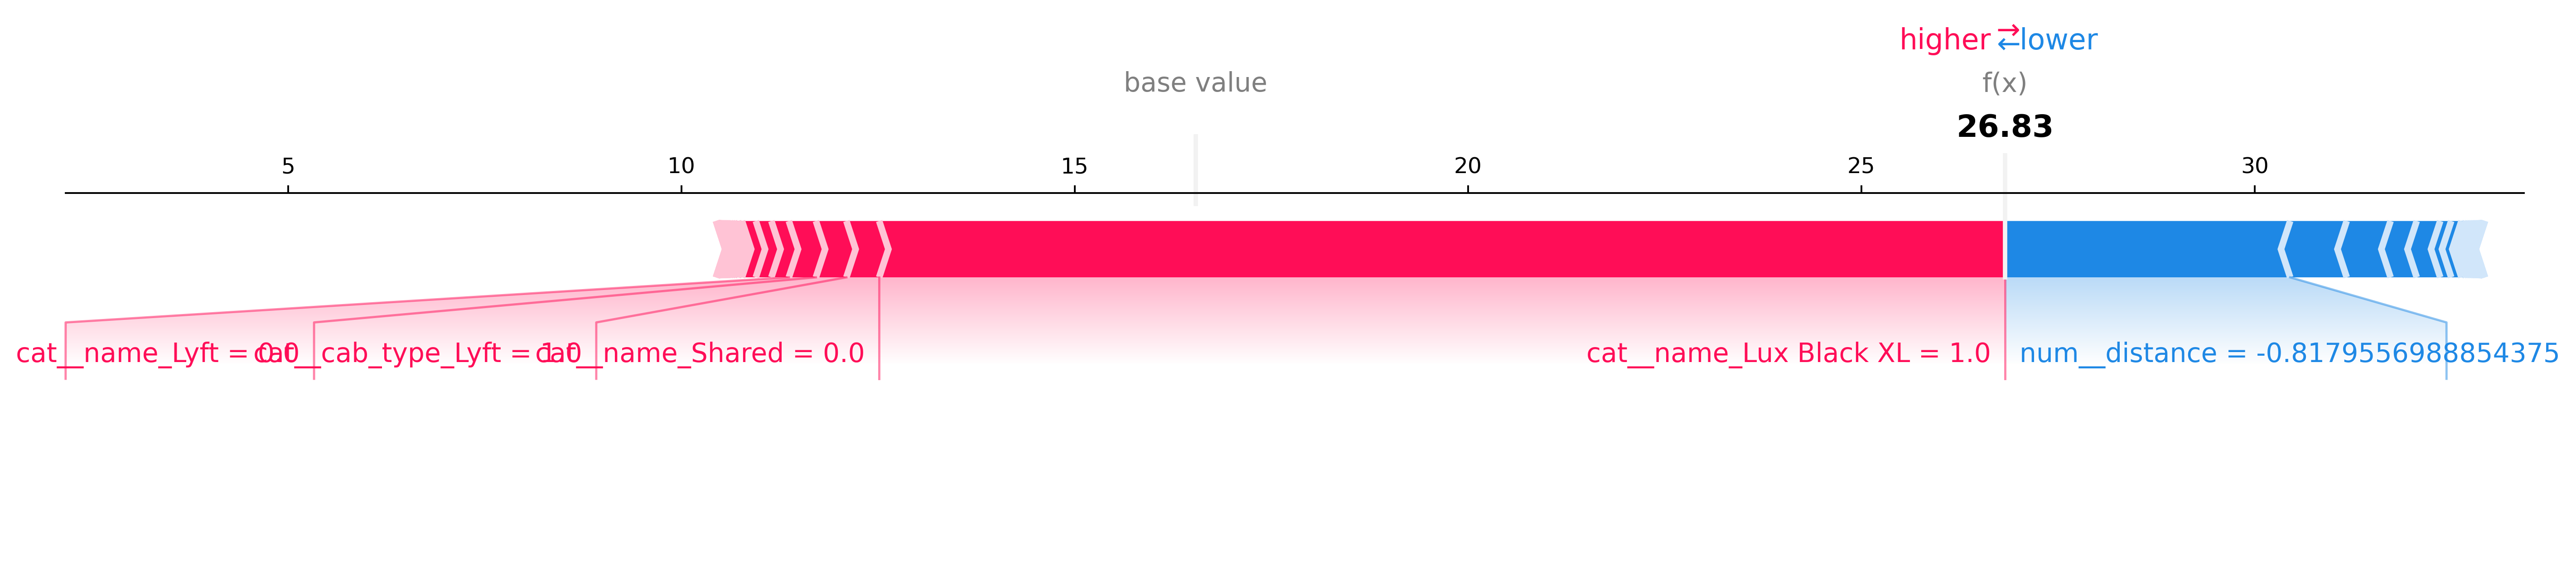

<Figure size 3500x1050 with 0 Axes>

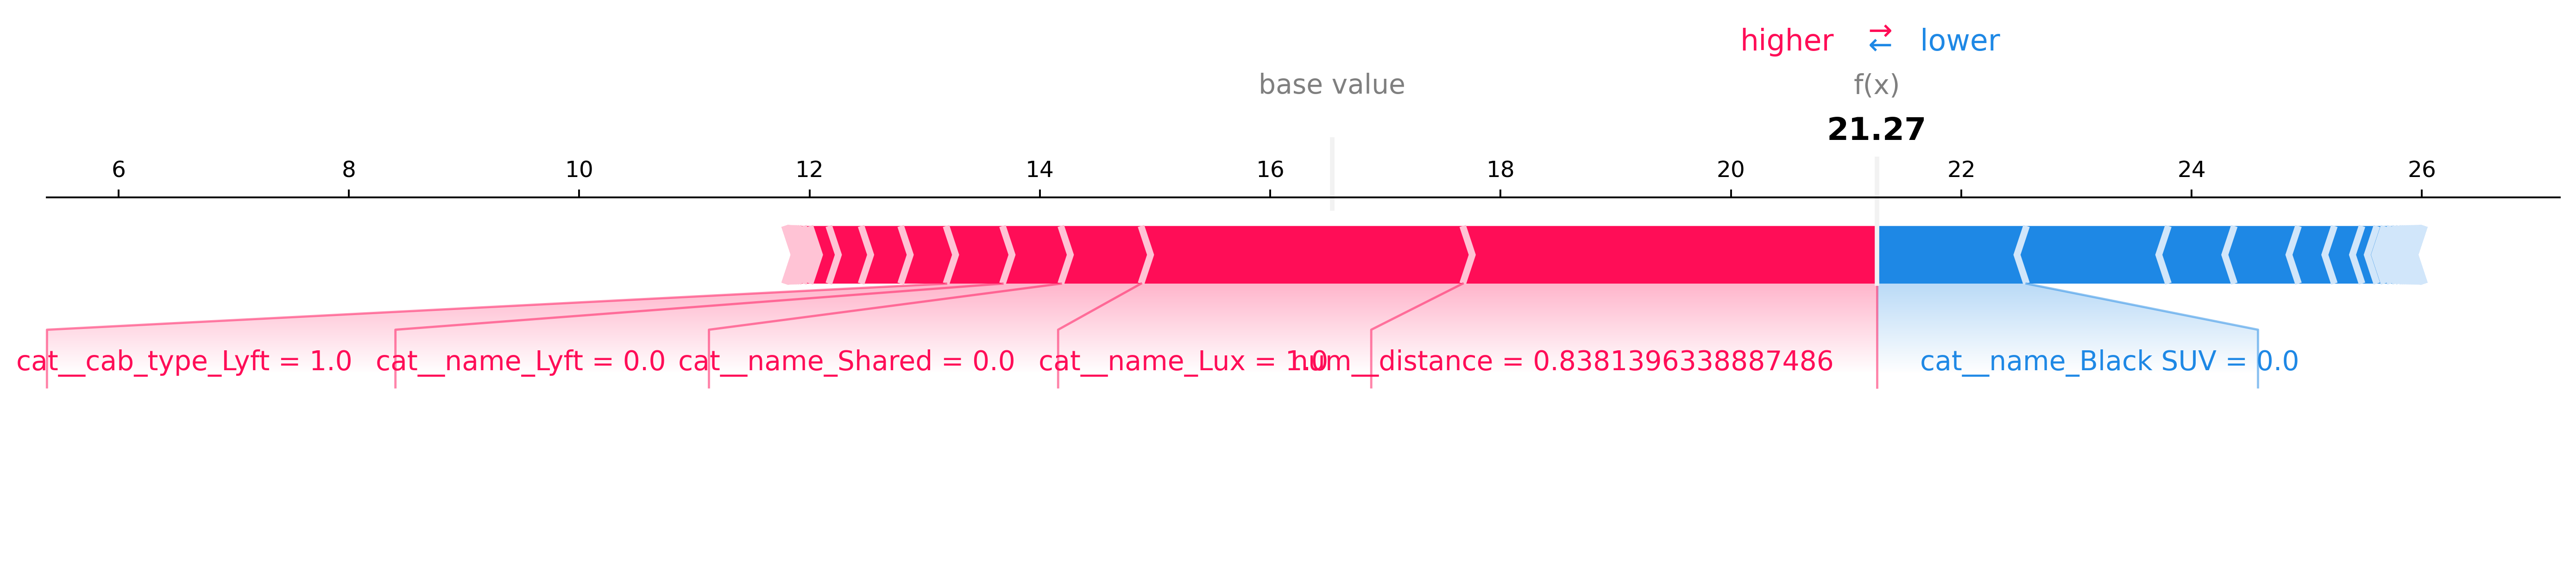

<Figure size 2240x1680 with 0 Axes>

In [56]:
# Generate force plots
for index in [0, 100, 200]:
    plt.gcf().set_size_inches(10, 3)
    shap.force_plot(explainer.expected_value, shap_values[index, :], df_test.iloc[index, :], matplotlib=True,feature_names = feature_names_encoded)
    plt.savefig(f"./Figures/shap_local_importance_{index}")

In [24]:
import numpy as np

numbers = np.linspace(0.01, 1, 11)
print(numbers.round(2))


[0.01 0.11 0.21 0.31 0.41 0.5  0.6  0.7  0.8  0.9  1.  ]
